<a href="https://colab.research.google.com/github/lrrong2020/A/blob/main/FYP_Pro_T4_overfit_solve_02_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import auth
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "MyDrive"
!google-drive-ocamlfuse "/content/gdrive/MyDrive"

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=7QwJA2bgeffUpPlSckRx8FAkCiw1XoZZMONFdOIRC9g'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/usr/bin/open: 882: www-browser: not found
/usr/bin/open: 882: links2: not found
/usr/bin/open: 882: elinks: not found
/usr/bin/open: 882: links: not found
/usr/bin/open: 882: lynx: not found
/usr/bin/open: 882: w3m: not found
xdg-open: no method available for opening '

Prep

In [2]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/data.zip /home





In [3]:
%cd /home
!unzip -nq /home/data.zip "train/*"



/home


#GitHub

In [4]:


!rm /home/data.zip

In [5]:
import pandas as pd #For reading csv files.
import numpy as np
import os
import matplotlib.pyplot as plt #For plotting.
import PIL.Image as Image #For working with image files.

#Importing torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader #For working with data.
from torchvision import models,transforms #For pretrained models,image transformations.
from torch.optim.lr_scheduler import StepLR

#manual seed for reproductivity and potential performance improvement
torch.manual_seed(3407)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [1]:
!cp /content/gdrive/MyDrive/Kaggle/unzip/allLabels.csv /home

In [9]:

path = "/home/"

#label csv
all_df = pd.read_csv(f"{path}allLabels.csv")

from sklearn.model_selection import train_test_split
# subset for hyperparameters tuning

part = 0.80
train_df, drop_df = train_test_split(all_df, test_size=part, random_state=42)
test_sample_size = round(7000 * (1 - part) )  #roughtly 1/3
train_df, test_df = train_test_split(train_df, test_size=test_sample_size, random_state=42)

# Assuming train_df is your original training DataFrame
# test_sample_size = 7000 # roughtly 1/3
# train_df, test_df = train_test_split(all_df, test_size=test_sample_size, random_state=42)

# Now split the remaining training data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f'No.of.training_samples: {len(train_df)}')
print(f'No.of.testing_samples: {len(test_df)}')
print(f'No.of.val_samples: {len(valid_df)}')

No.of.training_samples: 5062
No.of.testing_samples: 1400
No.of.val_samples: 563


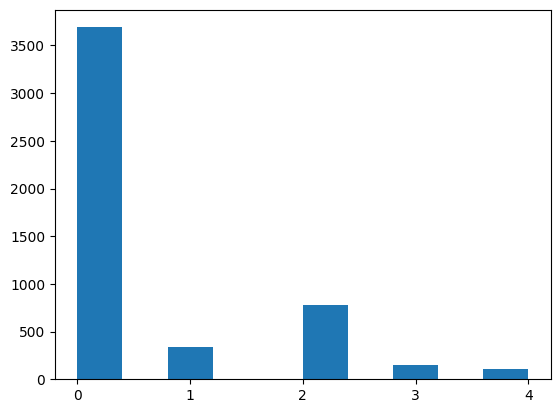

In [10]:
#Histogram of label counts.
train_df.level.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

In [11]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.2743, 2.9776, 1.3030, 6.9342, 9.3741], device='cuda:0')


In [ ]:
#For getting a random image from our training set.
# num = int(np.random.randint(0,len(train_df)-1,(1,))) #Picks a random number.
# sample_image = (f'{path}train/{train_df["image"][num]}.jpeg')#Image file.
# sample_image = Image.open(sample_image)
# plt.imshow(sample_image)
# plt.axis('off')
# plt.title(f'Class: {train_df["level"][num]}') #Class of the random image.
# plt.show()

In [12]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]
        image = Image.open(f'{self.data_path}/{image_id}.jpeg') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.


In [13]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_set = dataset(train_df,f'{path}train',image_transform=image_transform)
test_set = dataset(test_df,f'{path}train',image_transform=image_transform)
valid_set = dataset(valid_df,f'{path}train',image_transform=image_transform)

In [14]:
train_dataloader = DataLoader(train_set,batch_size=16,shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_set,batch_size=16,shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)

In [15]:
from torchvision.models import resnet50,ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT) #Downloads the resnet50 model which is pretrained on Imagenet dataset.
# Replace the Final layer of pretrained resnet50
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 5),
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


In [22]:
model = model.to(device) #Moves the model to the device.

In [17]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.

    total = 0
    correct = 0
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.


        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.

        running_loss += loss.item()

        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        accuracy = 100*(correct/total)

        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.

        #for memory
        torch.cuda.empty_cache()

        # Print some information every 100 batches
        if batch % 70 == 0:
            print(f'Batch {batch}/{len(dataloader)} processed, running loss: {running_loss:.6f}, correct predictions: {correct}, total: {total}')


    avg_loss = running_loss/len(dataloader) # Average loss for a single batch

    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    torch.save(model, '/content/gdrive/MyDrive/Kaggle/unzip/DR_ResNet50_02dropout.pt')
    return avg_loss, accuracy

In [18]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.

    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.

    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.eval() #Sets the model for evaluation.

    total = 0
    correct = 0
    running_loss = 0

    with torch.no_grad(): #No need to calculate the gradients.

        for x,y in dataloader:

            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss

            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            accuracy = 100*(correct/total)

    avg_loss = running_loss/len(dataloader) #Average loss per batch.

    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.

    return avg_loss, accuracy

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [20]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.

    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.

    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    # Initialize the learning rate scheduler
    # scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    best_valid_loss = float('inf')
    no_improve_epoch = 0

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        print("Epoch: %d, Learning Rate: %f " % (epoch, optimizer.param_groups[0]['lr']))
        train_loss, train_accuracy = train(train_dataloader,model,loss_fn,optimizer)
        valid_loss, valid_accuracy = validate(valid_dataloader,model,loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        plot_learning_curve(train_losses, valid_losses, train_accuracies, valid_accuracies)


        # Check if the validation loss improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improve_epoch = 0

            # Save the model when validation loss improves
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improve_epoch += 1

        # If the validation loss did not improve for 'patience' epochs, stop training
        if no_improve_epoch >= patience:
            print(f'Early stopping at epoch {epoch+1}, the validation loss did not improve for the last {patience} epochs')

            # Save to CSV
            df.to_csv('training_validation_metrics.csv', index=False)
            break

        # Step the learning rate scheduler
        # scheduler.step()
        scheduler.step(valid_loss)

        df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)

    print('\nTraining has completed!')

    # Save to CSV
    df.to_csv('training_validation_metrics.csv', index=False)

    return train_losses,valid_losses


Epoch 1/35
-------------------------------
Epoch: 0, Learning Rate: 0.005000 
Batch 0/317 processed, running loss: 1.623787, correct predictions: 3, total: 16
Batch 70/317 processed, running loss: 113.084386, correct predictions: 345, total: 1136
Batch 140/317 processed, running loss: 222.838323, correct predictions: 871, total: 2256
Batch 210/317 processed, running loss: 333.949819, correct predictions: 1582, total: 3376
Batch 280/317 processed, running loss: 441.828191, correct predictions: 2148, total: 4496

Training Loss per batch = 1.566147	Accuracy on Training set = 47.649151% [2412/5062]

Validation Loss per batch = 1.468200	Accuracy on Validation set = 61.278863% [345/563]
Train Loss: 1.5661, Train Accuracy: 47.6492
Valid Loss: 1.4682, Valid Accuracy: 61.2789


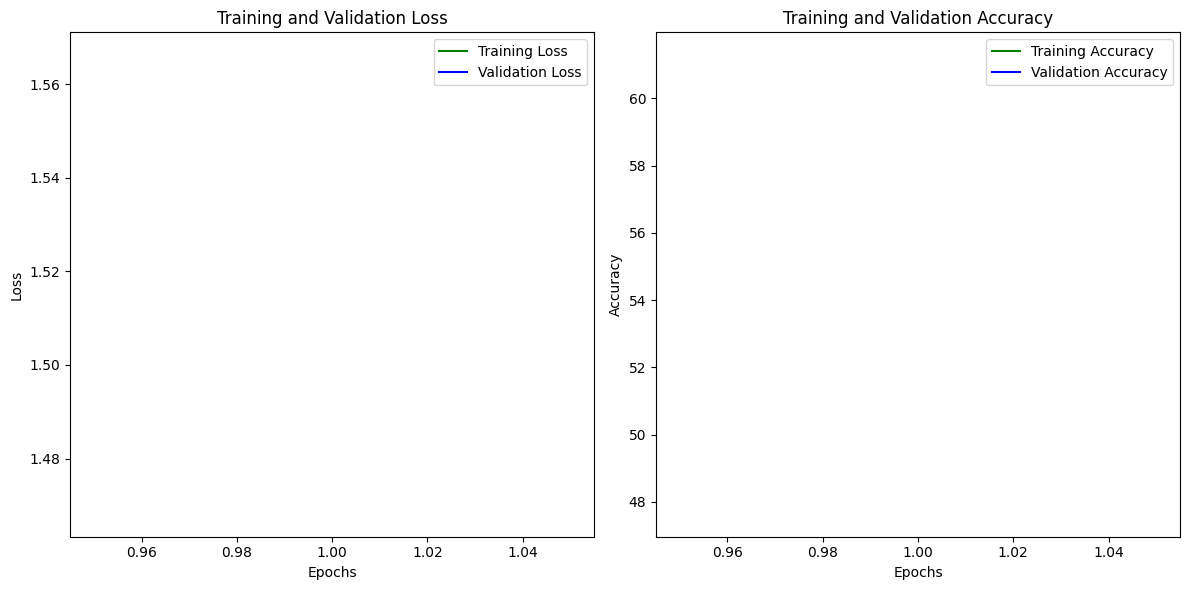


Epoch 2/35
-------------------------------
Epoch: 1, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.583010, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 103.662849, correct predictions: 665, total: 1136
Batch 140/317 processed, running loss: 202.920753, correct predictions: 1317, total: 2256
Batch 210/317 processed, running loss: 299.756747, correct predictions: 1960, total: 3376
Batch 280/317 processed, running loss: 394.016996, correct predictions: 2623, total: 4496

Training Loss per batch = 1.390773	Accuracy on Training set = 57.506914% [2911/5062]

Validation Loss per batch = 1.265461	Accuracy on Validation set = 50.976909% [287/563]
Train Loss: 1.3908, Train Accuracy: 57.5069
Valid Loss: 1.2655, Valid Accuracy: 50.9769


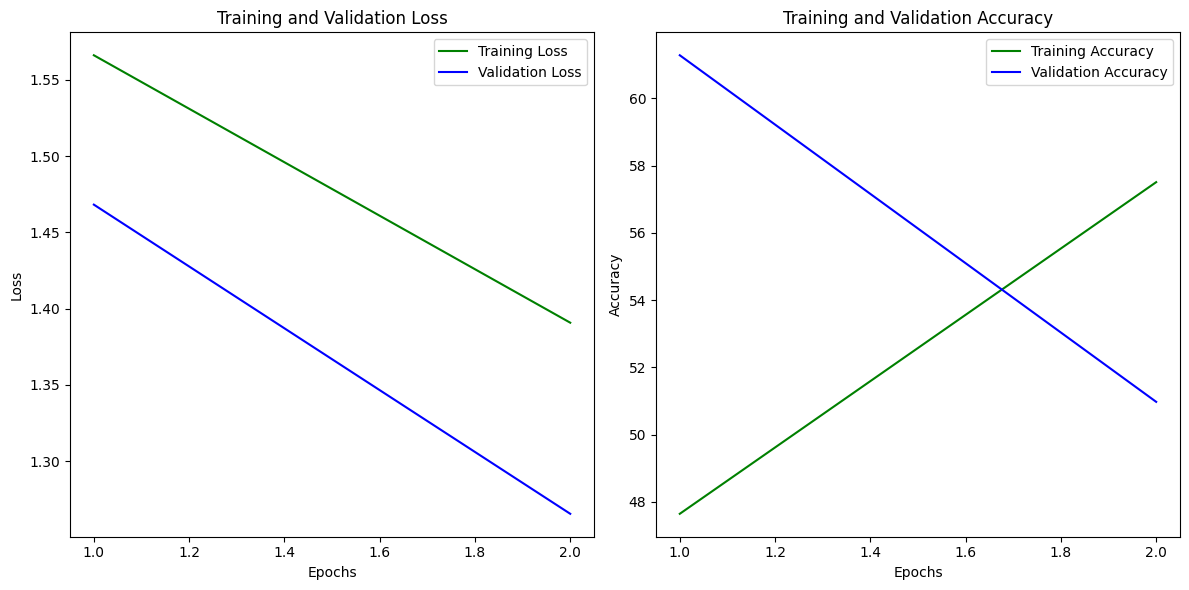


Epoch 3/35
-------------------------------
Epoch: 2, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.115569, correct predictions: 8, total: 16
Batch 70/317 processed, running loss: 87.245085, correct predictions: 731, total: 1136
Batch 140/317 processed, running loss: 171.023938, correct predictions: 1320, total: 2256
Batch 210/317 processed, running loss: 258.692948, correct predictions: 1982, total: 3376
Batch 280/317 processed, running loss: 348.663307, correct predictions: 2634, total: 4496

Training Loss per batch = 1.232125	Accuracy on Training set = 57.487159% [2910/5062]

Validation Loss per batch = 1.172072	Accuracy on Validation set = 66.962700% [377/563]
Train Loss: 1.2321, Train Accuracy: 57.4872
Valid Loss: 1.1721, Valid Accuracy: 66.9627


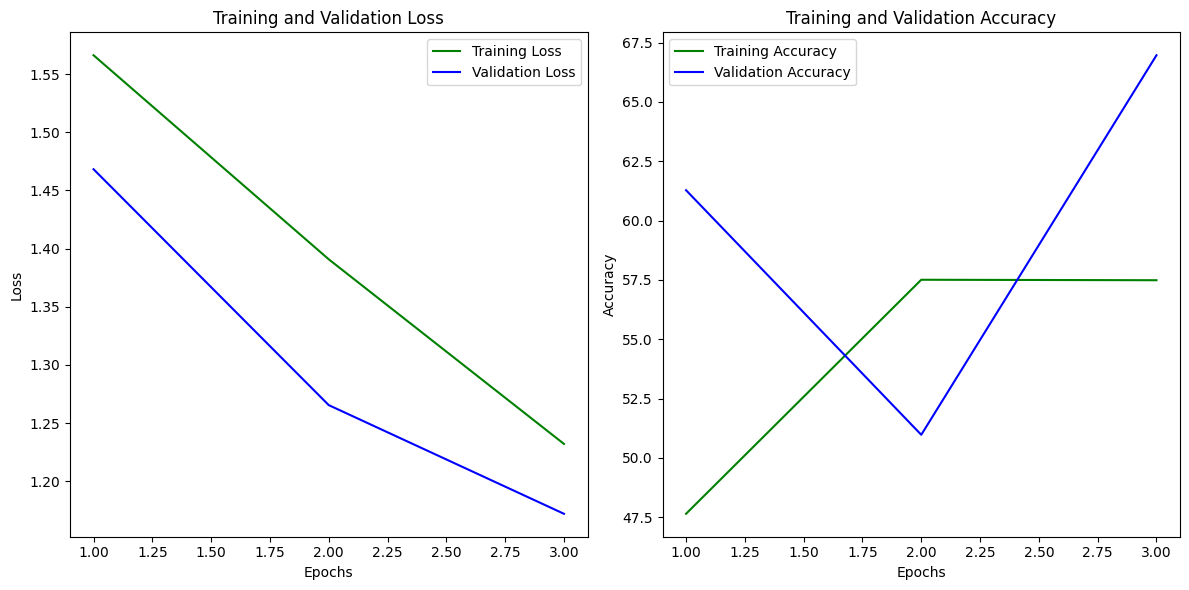


Epoch 4/35
-------------------------------
Epoch: 3, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.136326, correct predictions: 9, total: 16
Batch 70/317 processed, running loss: 81.604136, correct predictions: 671, total: 1136
Batch 140/317 processed, running loss: 167.818716, correct predictions: 1278, total: 2256
Batch 210/317 processed, running loss: 247.436172, correct predictions: 1921, total: 3376
Batch 280/317 processed, running loss: 328.022927, correct predictions: 2575, total: 4496

Training Loss per batch = 1.157093	Accuracy on Training set = 57.210589% [2896/5062]

Validation Loss per batch = 1.137987	Accuracy on Validation set = 76.554174% [431/563]
Train Loss: 1.1571, Train Accuracy: 57.2106
Valid Loss: 1.1380, Valid Accuracy: 76.5542


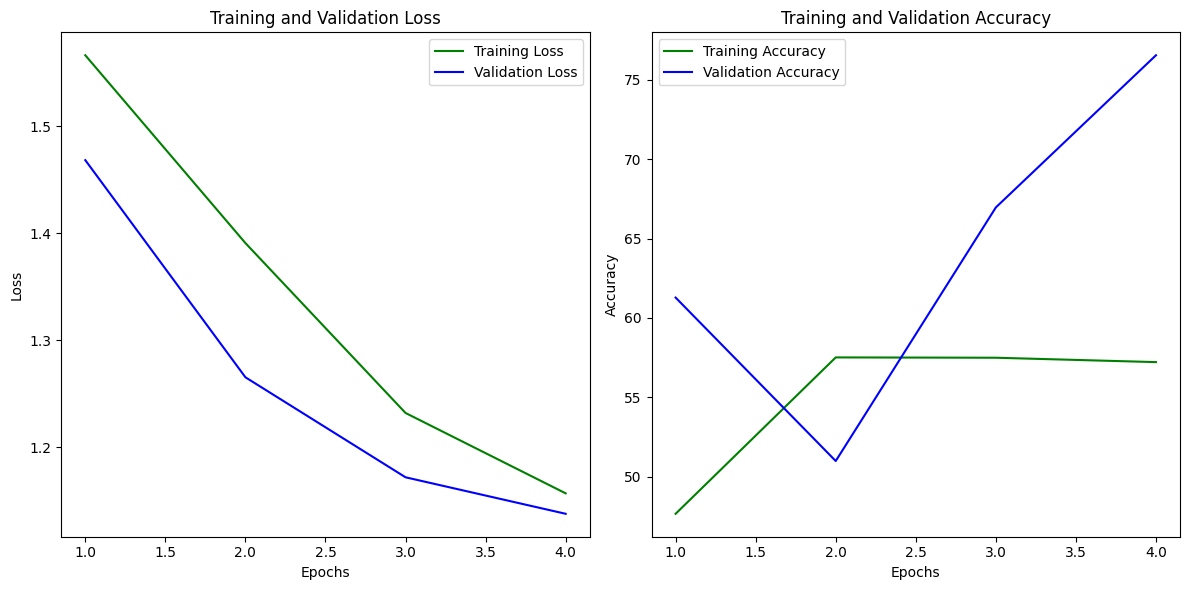


Epoch 5/35
-------------------------------
Epoch: 4, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.256356, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 74.134501, correct predictions: 759, total: 1136
Batch 140/317 processed, running loss: 152.152347, correct predictions: 1383, total: 2256
Batch 210/317 processed, running loss: 229.249381, correct predictions: 2037, total: 3376
Batch 280/317 processed, running loss: 306.069826, correct predictions: 2773, total: 4496

Training Loss per batch = 1.080088	Accuracy on Training set = 61.299881% [3103/5062]

Validation Loss per batch = 1.132654	Accuracy on Validation set = 59.857904% [337/563]
Train Loss: 1.0801, Train Accuracy: 61.2999
Valid Loss: 1.1327, Valid Accuracy: 59.8579


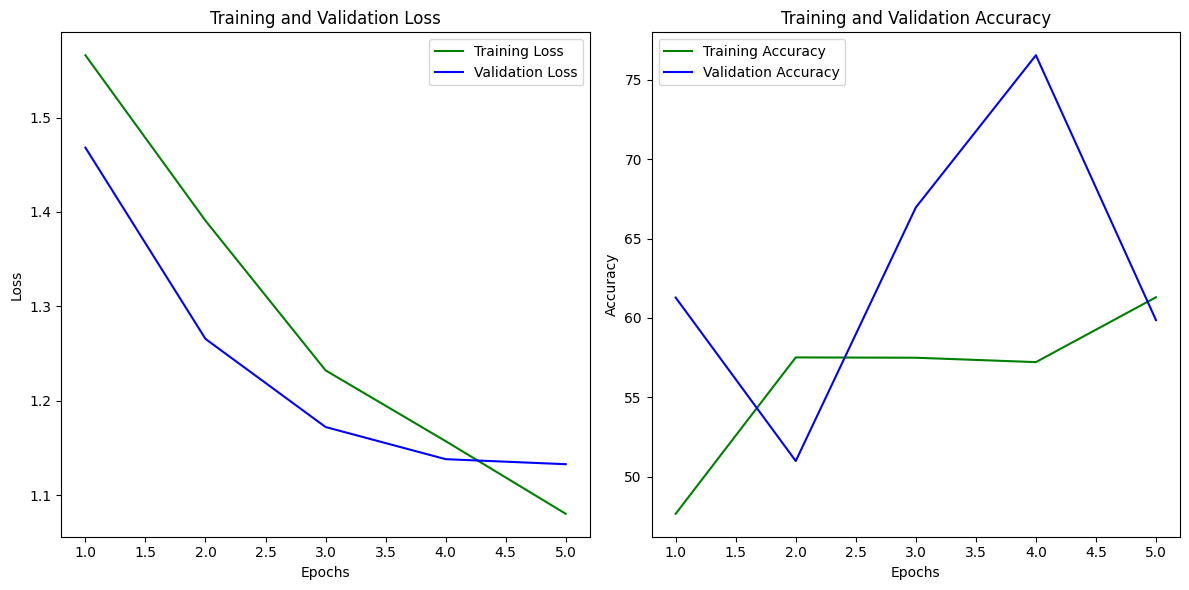


Epoch 6/35
-------------------------------
Epoch: 5, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.701091, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 74.702081, correct predictions: 660, total: 1136
Batch 140/317 processed, running loss: 141.832196, correct predictions: 1411, total: 2256
Batch 210/317 processed, running loss: 210.902132, correct predictions: 2105, total: 3376
Batch 280/317 processed, running loss: 282.725382, correct predictions: 2767, total: 4496

Training Loss per batch = 1.007098	Accuracy on Training set = 61.833267% [3130/5062]

Validation Loss per batch = 1.078484	Accuracy on Validation set = 71.047957% [400/563]
Train Loss: 1.0071, Train Accuracy: 61.8333
Valid Loss: 1.0785, Valid Accuracy: 71.0480


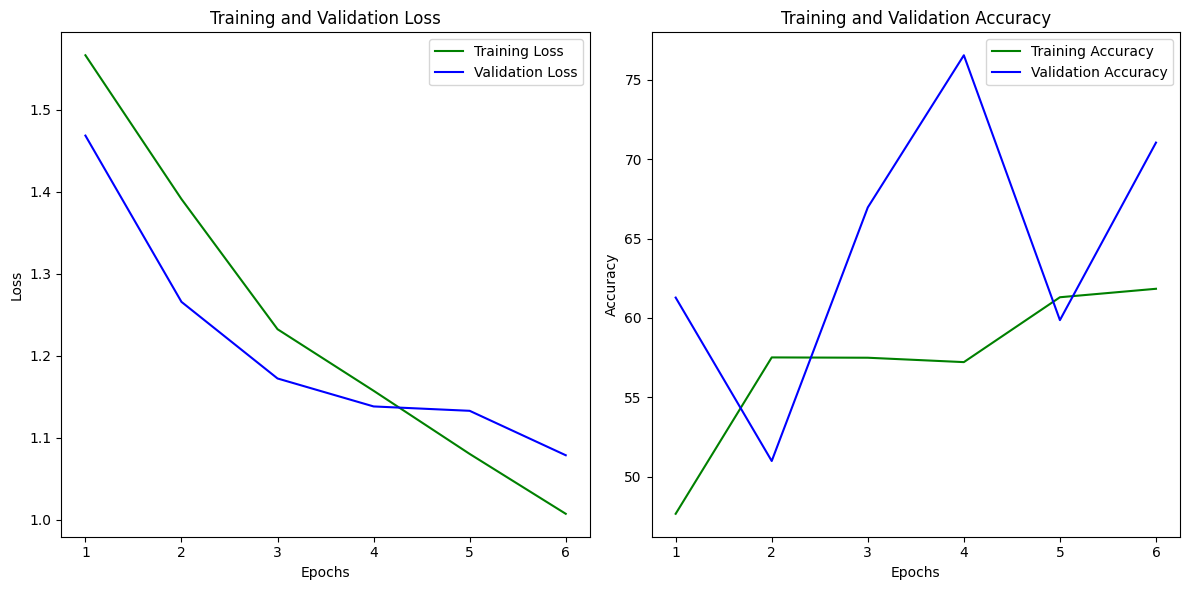


Epoch 7/35
-------------------------------
Epoch: 6, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 1.112772, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 64.721603, correct predictions: 676, total: 1136
Batch 140/317 processed, running loss: 132.480599, correct predictions: 1393, total: 2256
Batch 210/317 processed, running loss: 200.341231, correct predictions: 2095, total: 3376
Batch 280/317 processed, running loss: 267.498800, correct predictions: 2762, total: 4496

Training Loss per batch = 0.958824	Accuracy on Training set = 62.327143% [3155/5062]

Validation Loss per batch = 1.094154	Accuracy on Validation set = 73.889876% [416/563]
Train Loss: 0.9588, Train Accuracy: 62.3271
Valid Loss: 1.0942, Valid Accuracy: 73.8899


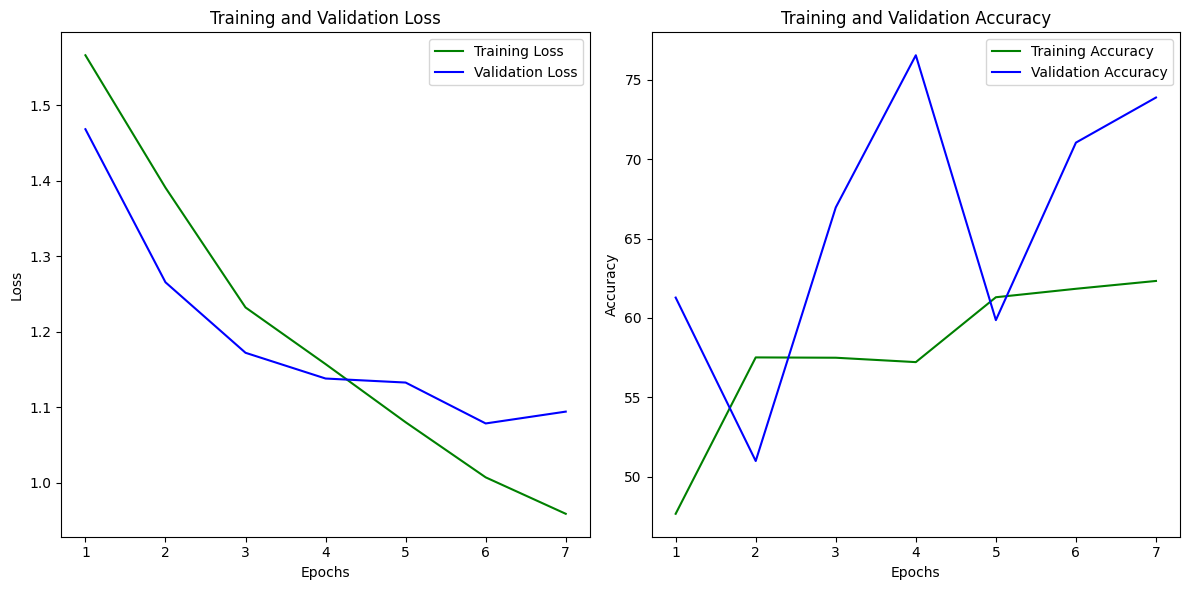


Epoch 8/35
-------------------------------
Epoch: 7, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.392278, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 59.481300, correct predictions: 749, total: 1136
Batch 140/317 processed, running loss: 116.660858, correct predictions: 1533, total: 2256
Batch 210/317 processed, running loss: 172.684474, correct predictions: 2246, total: 3376
Batch 280/317 processed, running loss: 236.194890, correct predictions: 2884, total: 4496

Training Loss per batch = 0.848011	Accuracy on Training set = 64.006322% [3240/5062]

Validation Loss per batch = 1.228153	Accuracy on Validation set = 77.442274% [436/563]
Train Loss: 0.8480, Train Accuracy: 64.0063
Valid Loss: 1.2282, Valid Accuracy: 77.4423


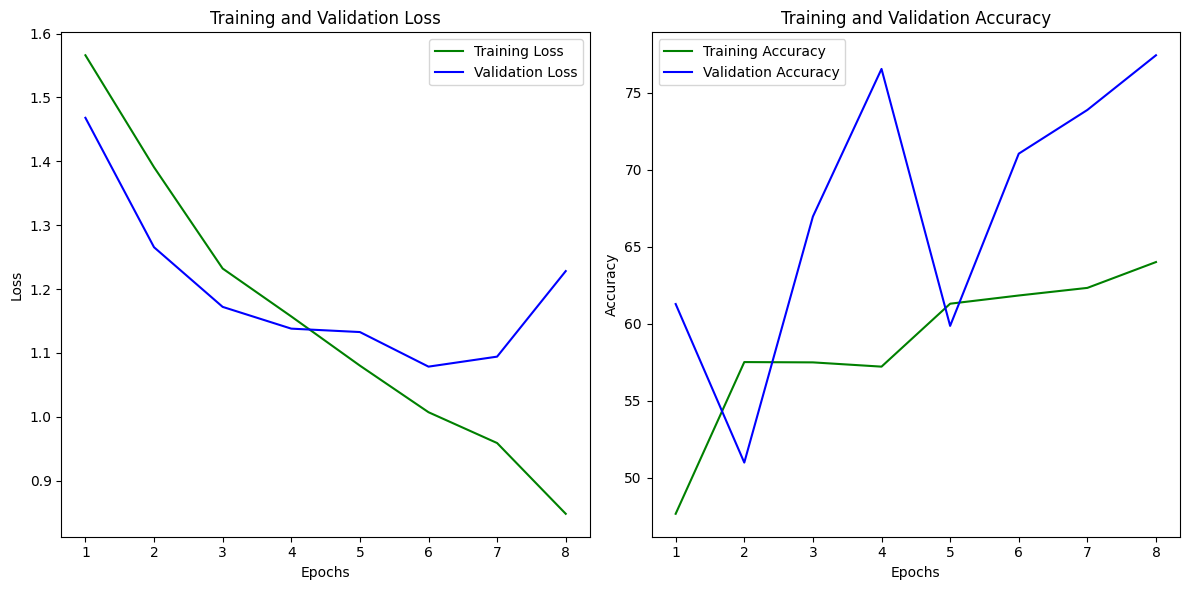


Epoch 9/35
-------------------------------
Epoch: 8, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.470730, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 60.125527, correct predictions: 784, total: 1136
Batch 140/317 processed, running loss: 115.459358, correct predictions: 1448, total: 2256
Batch 210/317 processed, running loss: 165.473235, correct predictions: 2135, total: 3376
Batch 280/317 processed, running loss: 214.767954, correct predictions: 2889, total: 4496

Training Loss per batch = 0.755266	Accuracy on Training set = 64.836033% [3282/5062]

Validation Loss per batch = 1.250567	Accuracy on Validation set = 77.797513% [438/563]
Train Loss: 0.7553, Train Accuracy: 64.8360
Valid Loss: 1.2506, Valid Accuracy: 77.7975


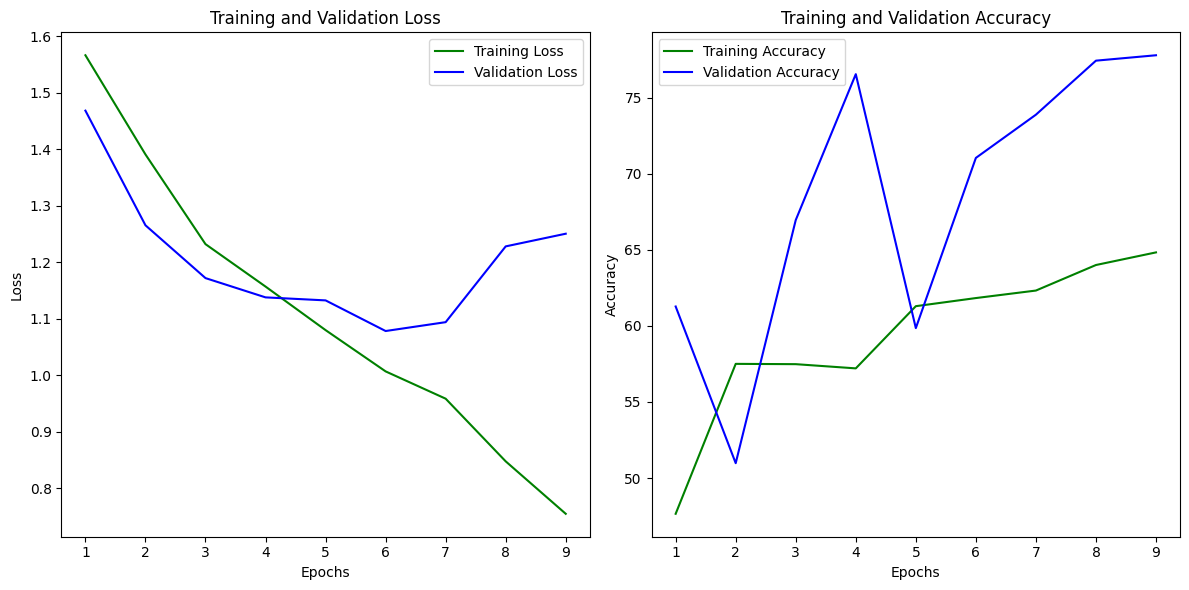


Epoch 10/35
-------------------------------
Epoch: 9, Learning Rate: 0.005000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.344396, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 46.187594, correct predictions: 782, total: 1136
Batch 140/317 processed, running loss: 102.900955, correct predictions: 1496, total: 2256
Batch 210/317 processed, running loss: 151.764339, correct predictions: 2239, total: 3376
Batch 280/317 processed, running loss: 203.585971, correct predictions: 3008, total: 4496

Training Loss per batch = 0.719303	Accuracy on Training set = 67.088107% [3396/5062]

Validation Loss per batch = 1.388517	Accuracy on Validation set = 66.252220% [373/563]
Train Loss: 0.7193, Train Accuracy: 67.0881
Valid Loss: 1.3885, Valid Accuracy: 66.2522


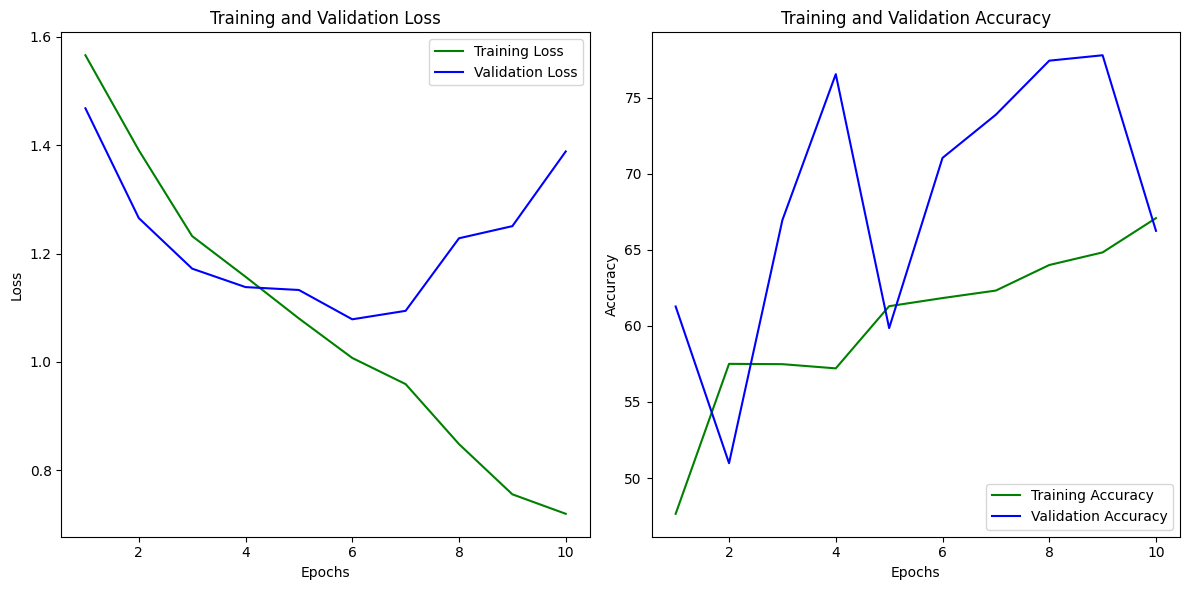


Epoch 11/35
-------------------------------
Epoch: 10, Learning Rate: 0.000500 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.342939, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 43.959688, correct predictions: 793, total: 1136
Batch 140/317 processed, running loss: 88.763991, correct predictions: 1593, total: 2256
Batch 210/317 processed, running loss: 131.180341, correct predictions: 2421, total: 3376
Batch 280/317 processed, running loss: 169.535280, correct predictions: 3241, total: 4496

Training Loss per batch = 0.597697	Accuracy on Training set = 72.520743% [3671/5062]

Validation Loss per batch = 1.297582	Accuracy on Validation set = 68.738899% [387/563]
Train Loss: 0.5977, Train Accuracy: 72.5207
Valid Loss: 1.2976, Valid Accuracy: 68.7389


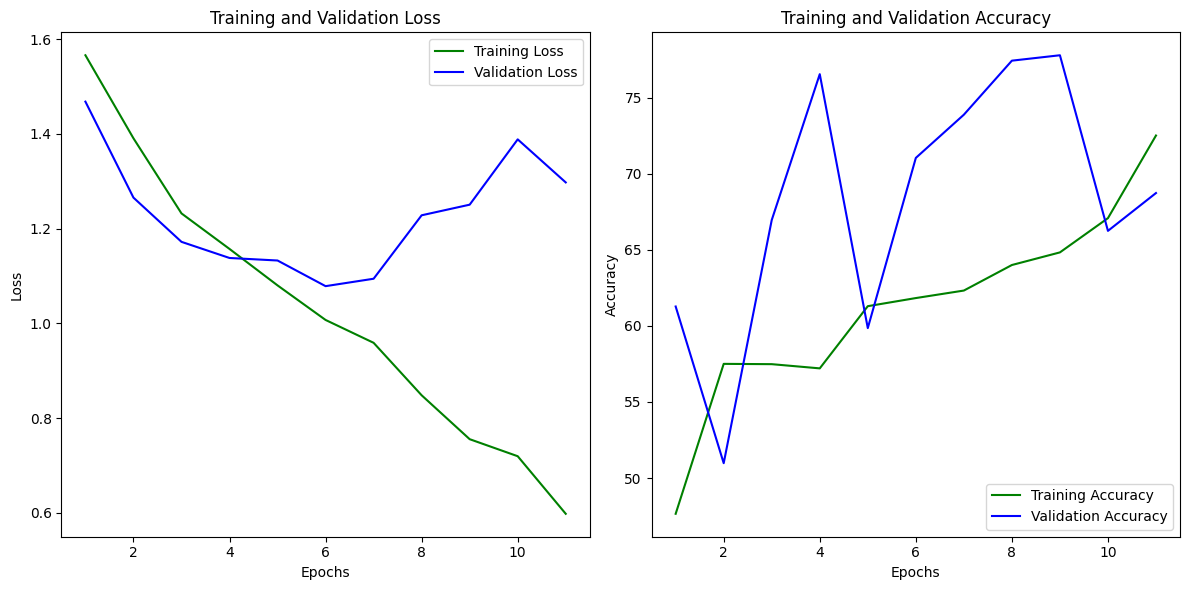


Epoch 12/35
-------------------------------
Epoch: 11, Learning Rate: 0.000500 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.157880, correct predictions: 16, total: 16
Batch 70/317 processed, running loss: 40.941444, correct predictions: 849, total: 1136
Batch 140/317 processed, running loss: 75.443047, correct predictions: 1712, total: 2256
Batch 210/317 processed, running loss: 114.526836, correct predictions: 2543, total: 3376
Batch 280/317 processed, running loss: 153.143050, correct predictions: 3390, total: 4496

Training Loss per batch = 0.536882	Accuracy on Training set = 75.740814% [3834/5062]

Validation Loss per batch = 1.216130	Accuracy on Validation set = 64.120782% [361/563]
Train Loss: 0.5369, Train Accuracy: 75.7408
Valid Loss: 1.2161, Valid Accuracy: 64.1208


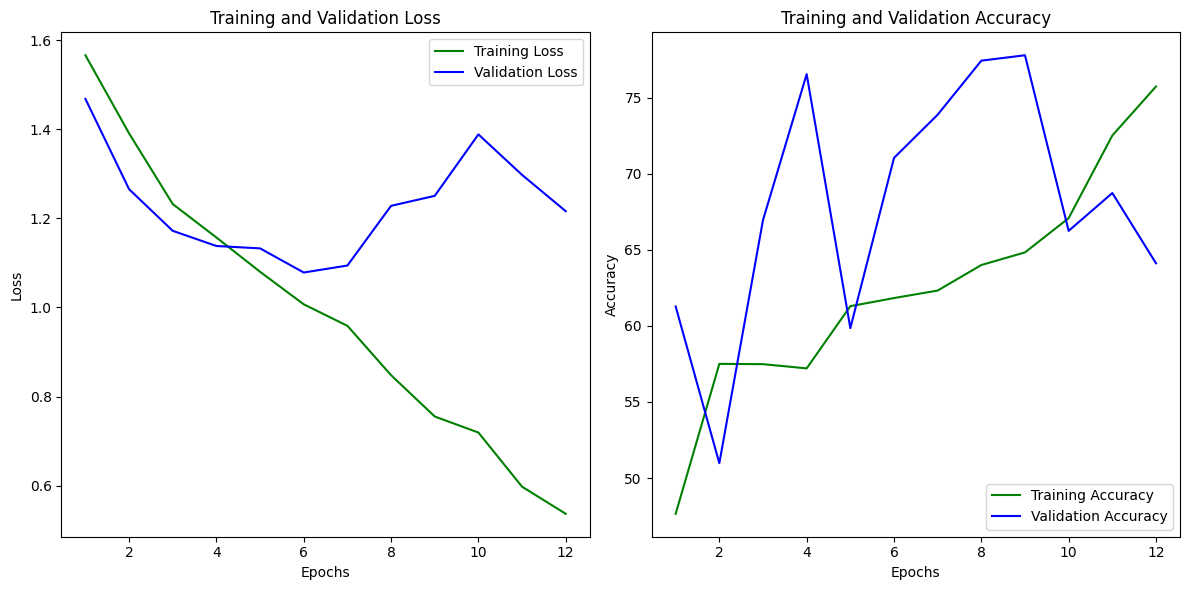


Epoch 13/35
-------------------------------
Epoch: 12, Learning Rate: 0.000500 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.423766, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 35.555805, correct predictions: 880, total: 1136
Batch 140/317 processed, running loss: 70.482873, correct predictions: 1735, total: 2256
Batch 210/317 processed, running loss: 104.207700, correct predictions: 2596, total: 3376
Batch 280/317 processed, running loss: 137.140640, correct predictions: 3440, total: 4496

Training Loss per batch = 0.489264	Accuracy on Training set = 76.511260% [3873/5062]

Validation Loss per batch = 1.202348	Accuracy on Validation set = 66.607460% [375/563]
Train Loss: 0.4893, Train Accuracy: 76.5113
Valid Loss: 1.2023, Valid Accuracy: 66.6075


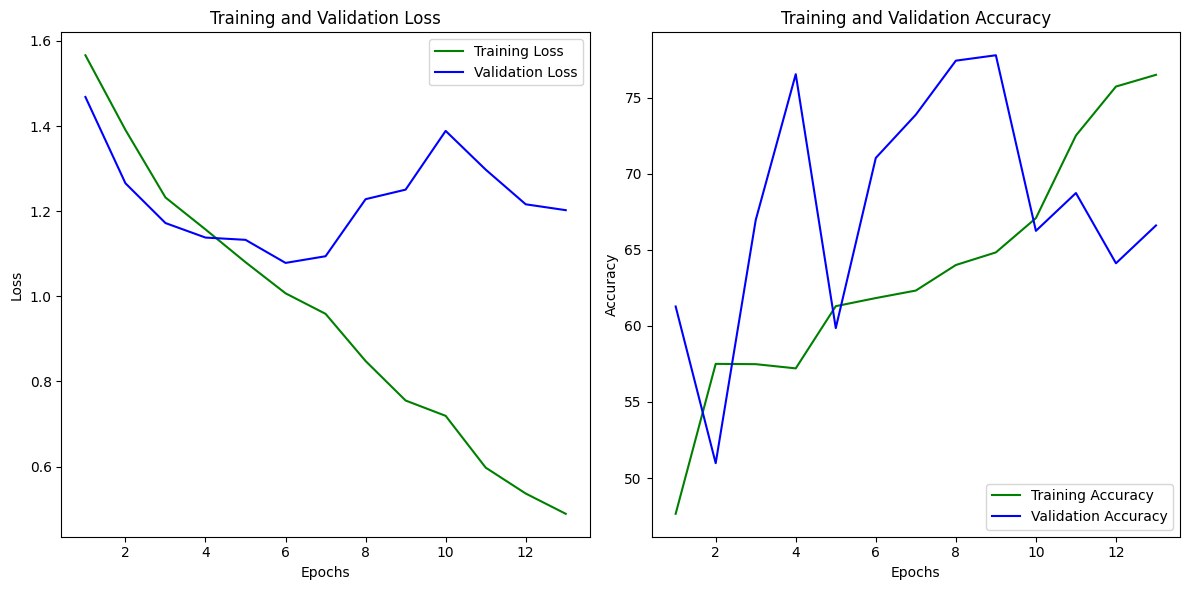


Epoch 14/35
-------------------------------
Epoch: 13, Learning Rate: 0.000500 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.604437, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 33.033573, correct predictions: 875, total: 1136
Batch 140/317 processed, running loss: 63.284311, correct predictions: 1737, total: 2256
Batch 210/317 processed, running loss: 95.687835, correct predictions: 2608, total: 3376
Batch 280/317 processed, running loss: 131.612400, correct predictions: 3455, total: 4496

Training Loss per batch = 0.466823	Accuracy on Training set = 76.827341% [3889/5062]

Validation Loss per batch = 1.234904	Accuracy on Validation set = 62.522202% [352/563]
Train Loss: 0.4668, Train Accuracy: 76.8273
Valid Loss: 1.2349, Valid Accuracy: 62.5222


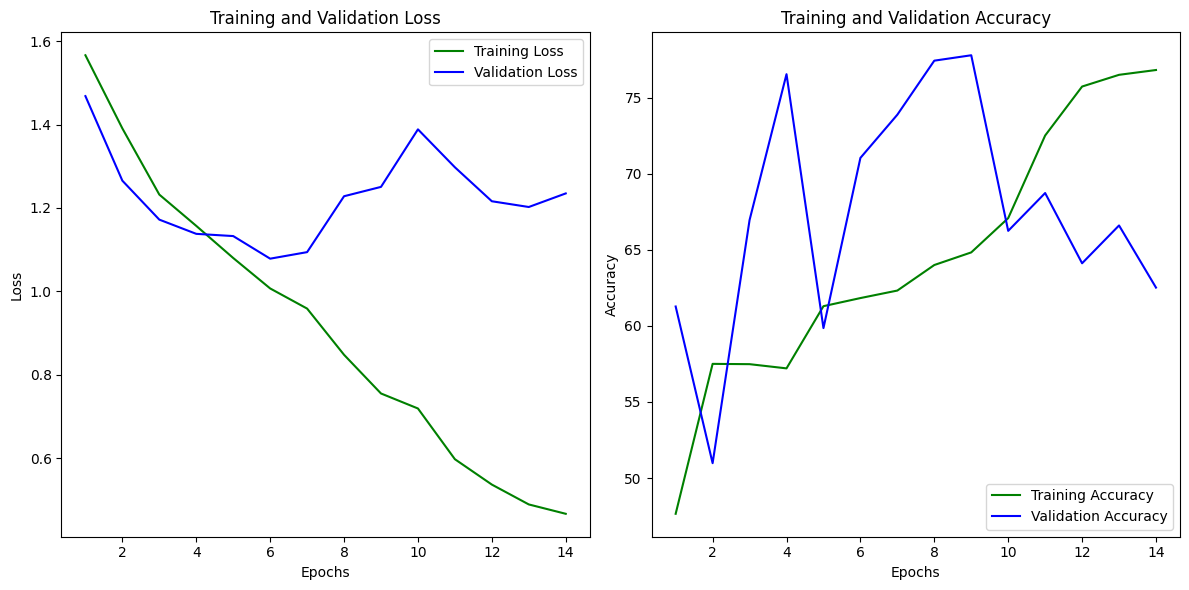


Epoch 15/35
-------------------------------
Epoch: 14, Learning Rate: 0.000050 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.180868, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 34.127620, correct predictions: 864, total: 1136
Batch 140/317 processed, running loss: 64.824496, correct predictions: 1701, total: 2256
Batch 210/317 processed, running loss: 96.165737, correct predictions: 2531, total: 3376
Batch 280/317 processed, running loss: 126.359650, correct predictions: 3393, total: 4496

Training Loss per batch = 0.447464	Accuracy on Training set = 75.681549% [3831/5062]

Validation Loss per batch = 1.242333	Accuracy on Validation set = 64.653641% [364/563]
Train Loss: 0.4475, Train Accuracy: 75.6815
Valid Loss: 1.2423, Valid Accuracy: 64.6536


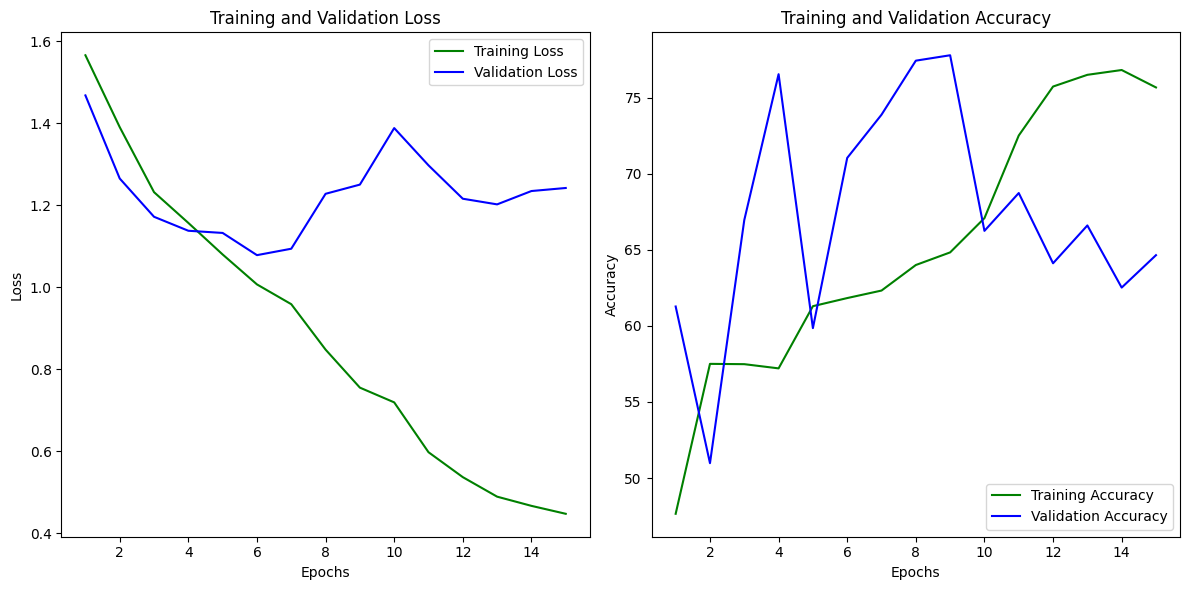


Epoch 16/35
-------------------------------
Epoch: 15, Learning Rate: 0.000050 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.482190, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 33.806916, correct predictions: 855, total: 1136
Batch 140/317 processed, running loss: 65.310498, correct predictions: 1702, total: 2256
Batch 210/317 processed, running loss: 96.012167, correct predictions: 2567, total: 3376
Batch 280/317 processed, running loss: 125.395727, correct predictions: 3415, total: 4496

Training Loss per batch = 0.443416	Accuracy on Training set = 76.491505% [3872/5062]

Validation Loss per batch = 1.267044	Accuracy on Validation set = 61.278863% [345/563]
Train Loss: 0.4434, Train Accuracy: 76.4915
Valid Loss: 1.2670, Valid Accuracy: 61.2789


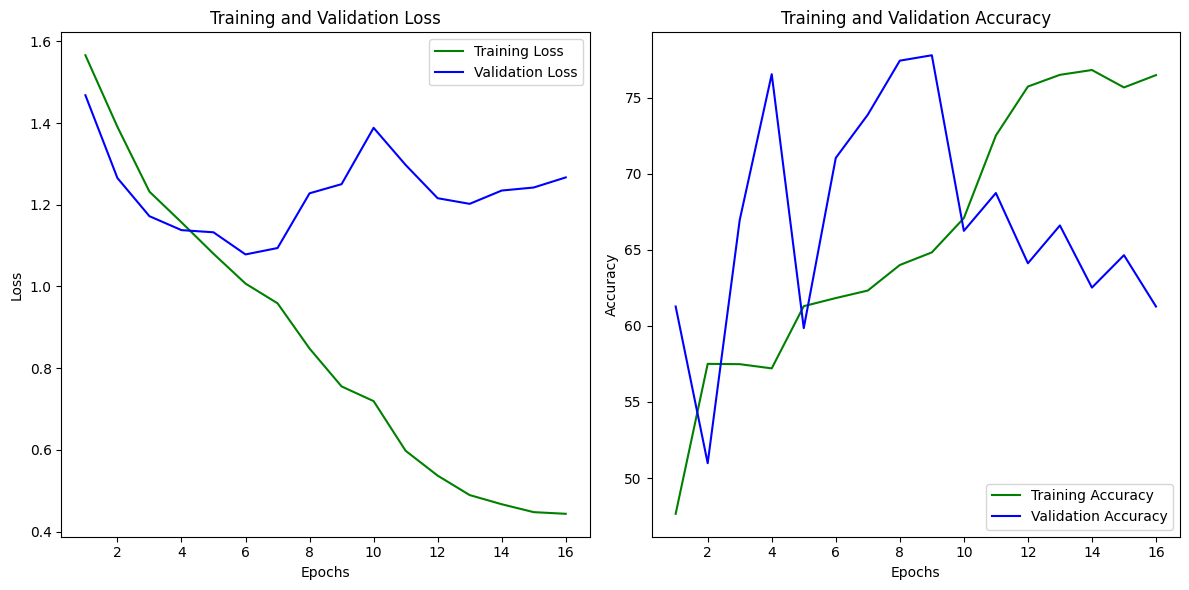


Epoch 17/35
-------------------------------
Epoch: 16, Learning Rate: 0.000050 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.669797, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 33.062847, correct predictions: 858, total: 1136
Batch 140/317 processed, running loss: 66.343576, correct predictions: 1716, total: 2256
Batch 210/317 processed, running loss: 96.938574, correct predictions: 2559, total: 3376
Batch 280/317 processed, running loss: 128.835754, correct predictions: 3405, total: 4496

Training Loss per batch = 0.450396	Accuracy on Training set = 76.293955% [3862/5062]

Validation Loss per batch = 1.247438	Accuracy on Validation set = 64.831261% [365/563]
Train Loss: 0.4504, Train Accuracy: 76.2940
Valid Loss: 1.2474, Valid Accuracy: 64.8313


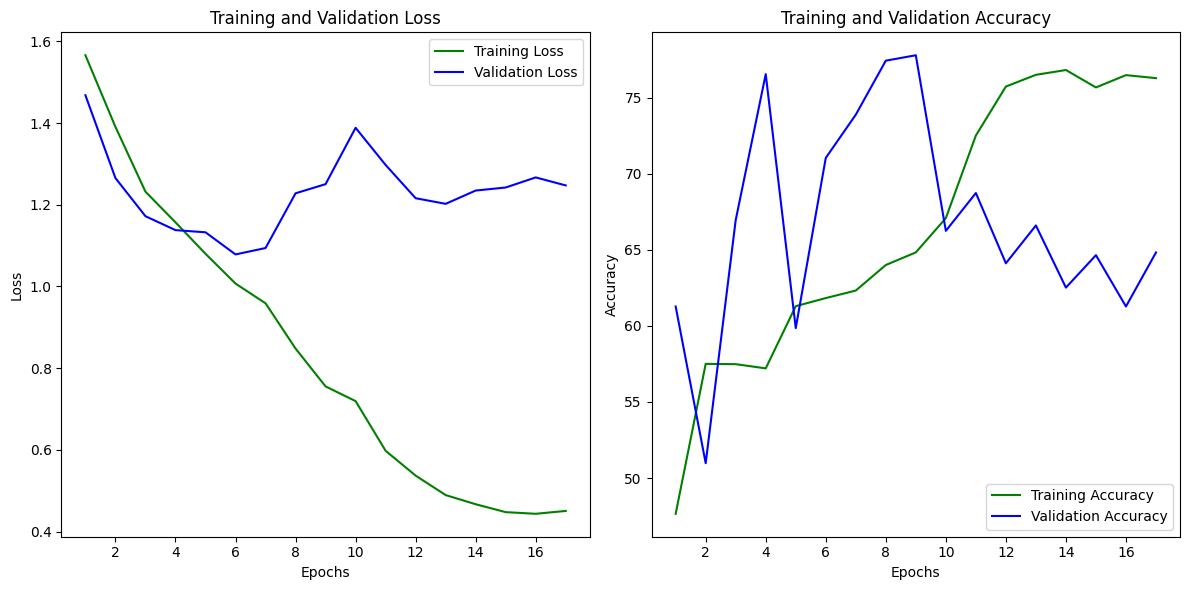


Epoch 18/35
-------------------------------
Epoch: 17, Learning Rate: 0.000050 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.575572, correct predictions: 9, total: 16
Batch 70/317 processed, running loss: 30.556515, correct predictions: 874, total: 1136
Batch 140/317 processed, running loss: 61.146234, correct predictions: 1740, total: 2256
Batch 210/317 processed, running loss: 90.983722, correct predictions: 2624, total: 3376
Batch 280/317 processed, running loss: 122.773635, correct predictions: 3503, total: 4496

Training Loss per batch = 0.436052	Accuracy on Training set = 77.894113% [3943/5062]

Validation Loss per batch = 1.232593	Accuracy on Validation set = 66.607460% [375/563]
Train Loss: 0.4361, Train Accuracy: 77.8941
Valid Loss: 1.2326, Valid Accuracy: 66.6075


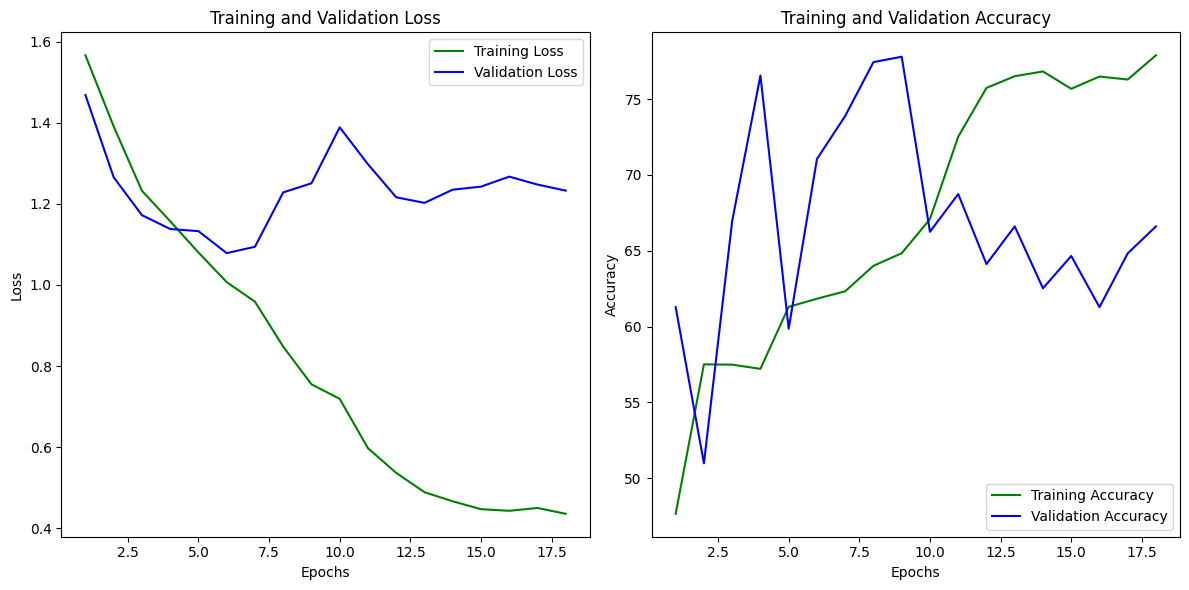


Epoch 19/35
-------------------------------
Epoch: 18, Learning Rate: 0.000005 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.330831, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 27.786679, correct predictions: 903, total: 1136
Batch 140/317 processed, running loss: 57.550046, correct predictions: 1779, total: 2256
Batch 210/317 processed, running loss: 89.605820, correct predictions: 2638, total: 3376
Batch 280/317 processed, running loss: 124.356465, correct predictions: 3488, total: 4496

Training Loss per batch = 0.444234	Accuracy on Training set = 77.499012% [3923/5062]

Validation Loss per batch = 1.243746	Accuracy on Validation set = 67.140320% [378/563]
Train Loss: 0.4442, Train Accuracy: 77.4990
Valid Loss: 1.2437, Valid Accuracy: 67.1403


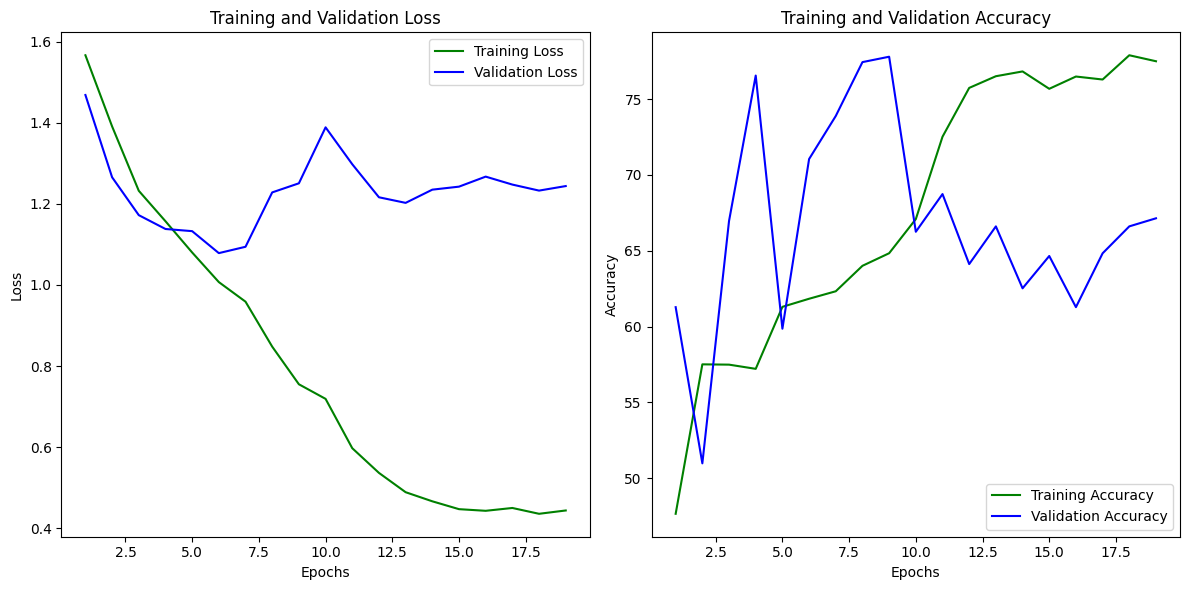


Epoch 20/35
-------------------------------
Epoch: 19, Learning Rate: 0.000005 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.311555, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 32.436173, correct predictions: 875, total: 1136
Batch 140/317 processed, running loss: 62.472600, correct predictions: 1737, total: 2256
Batch 210/317 processed, running loss: 91.843380, correct predictions: 2624, total: 3376
Batch 280/317 processed, running loss: 123.771515, correct predictions: 3502, total: 4496

Training Loss per batch = 0.442143	Accuracy on Training set = 77.913868% [3944/5062]

Validation Loss per batch = 1.238166	Accuracy on Validation set = 63.765542% [359/563]
Train Loss: 0.4421, Train Accuracy: 77.9139
Valid Loss: 1.2382, Valid Accuracy: 63.7655


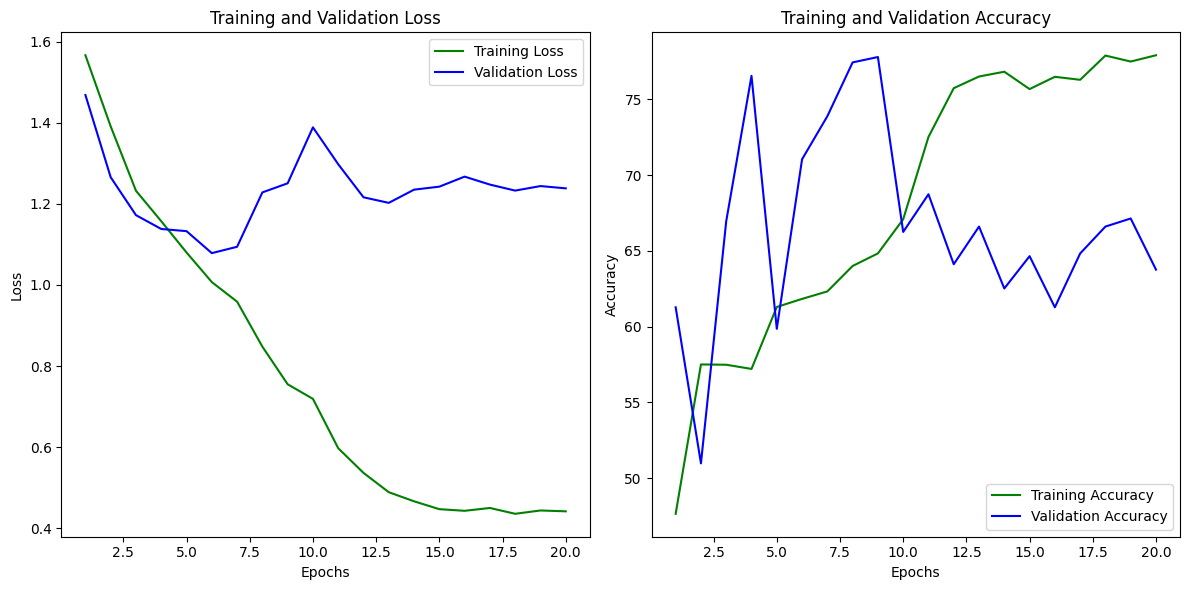


Epoch 21/35
-------------------------------
Epoch: 20, Learning Rate: 0.000005 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.551849, correct predictions: 10, total: 16
Batch 70/317 processed, running loss: 30.379163, correct predictions: 887, total: 1136
Batch 140/317 processed, running loss: 60.549522, correct predictions: 1750, total: 2256
Batch 210/317 processed, running loss: 95.330324, correct predictions: 2627, total: 3376
Batch 280/317 processed, running loss: 123.727933, correct predictions: 3514, total: 4496

Training Loss per batch = 0.440430	Accuracy on Training set = 78.210194% [3959/5062]

Validation Loss per batch = 1.285718	Accuracy on Validation set = 64.120782% [361/563]
Train Loss: 0.4404, Train Accuracy: 78.2102
Valid Loss: 1.2857, Valid Accuracy: 64.1208


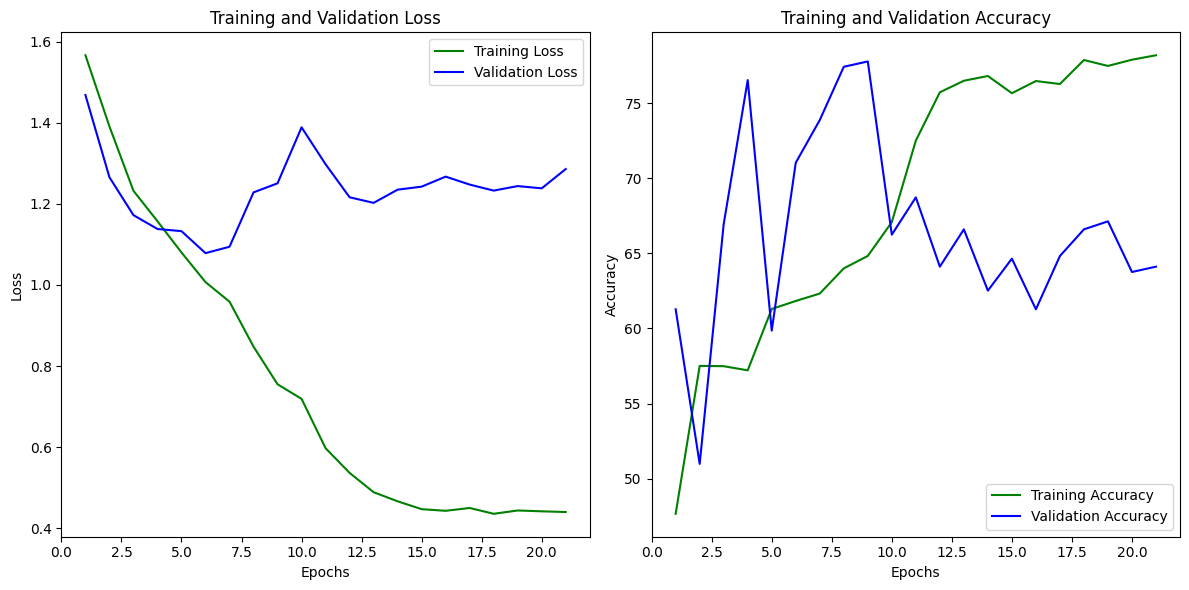


Epoch 22/35
-------------------------------
Epoch: 21, Learning Rate: 0.000005 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.387390, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 29.747887, correct predictions: 903, total: 1136
Batch 140/317 processed, running loss: 59.254105, correct predictions: 1782, total: 2256
Batch 210/317 processed, running loss: 88.900093, correct predictions: 2666, total: 3376
Batch 280/317 processed, running loss: 123.403918, correct predictions: 3508, total: 4496

Training Loss per batch = 0.439168	Accuracy on Training set = 77.795338% [3938/5062]

Validation Loss per batch = 1.242493	Accuracy on Validation set = 65.008881% [366/563]
Train Loss: 0.4392, Train Accuracy: 77.7953
Valid Loss: 1.2425, Valid Accuracy: 65.0089


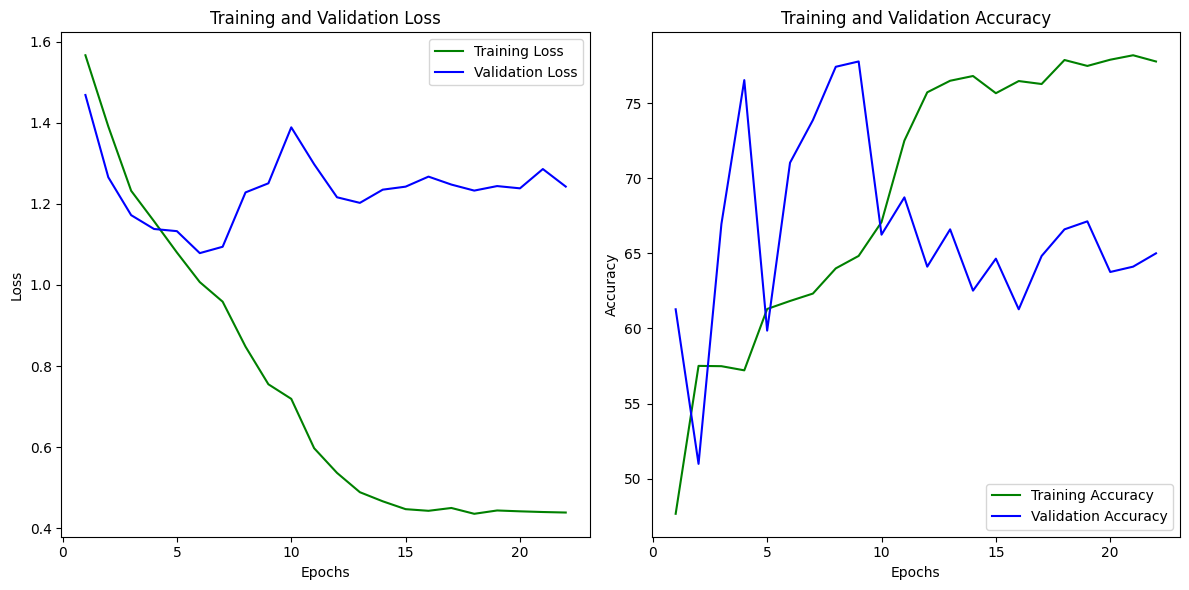


Epoch 23/35
-------------------------------
Epoch: 22, Learning Rate: 0.000001 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.239807, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 29.392500, correct predictions: 894, total: 1136
Batch 140/317 processed, running loss: 60.670591, correct predictions: 1755, total: 2256
Batch 210/317 processed, running loss: 92.369208, correct predictions: 2637, total: 3376
Batch 280/317 processed, running loss: 122.834325, correct predictions: 3516, total: 4496

Training Loss per batch = 0.439272	Accuracy on Training set = 77.992888% [3948/5062]

Validation Loss per batch = 1.224377	Accuracy on Validation set = 66.429840% [374/563]
Train Loss: 0.4393, Train Accuracy: 77.9929
Valid Loss: 1.2244, Valid Accuracy: 66.4298


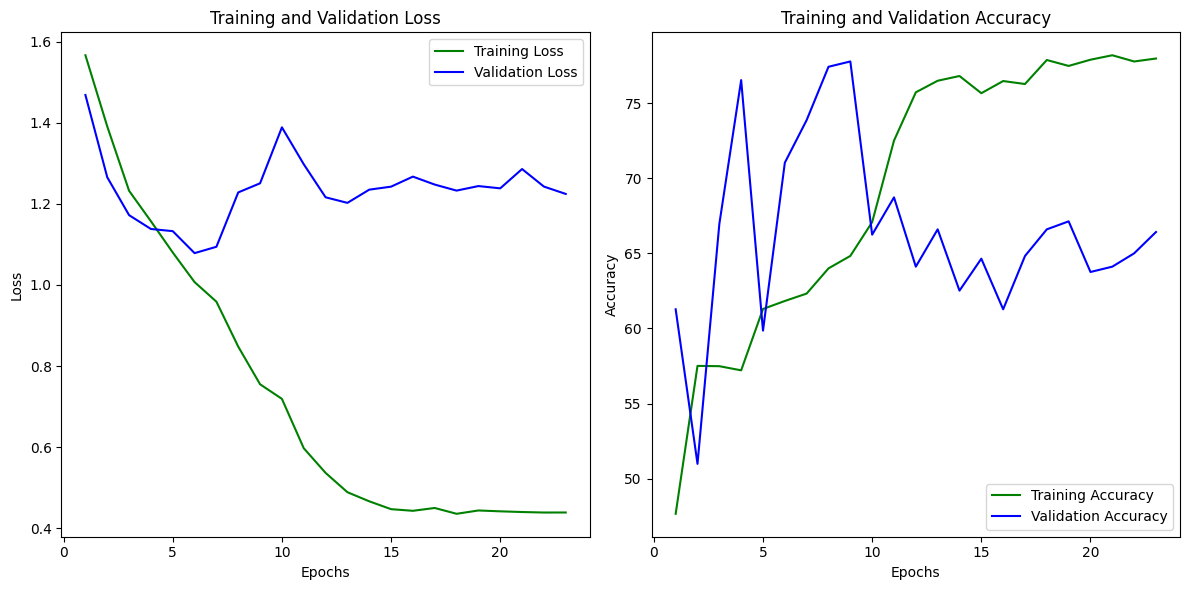


Epoch 24/35
-------------------------------
Epoch: 23, Learning Rate: 0.000001 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.759352, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 31.217751, correct predictions: 890, total: 1136
Batch 140/317 processed, running loss: 62.302572, correct predictions: 1758, total: 2256
Batch 210/317 processed, running loss: 92.108613, correct predictions: 2615, total: 3376
Batch 280/317 processed, running loss: 120.170799, correct predictions: 3508, total: 4496

Training Loss per batch = 0.422778	Accuracy on Training set = 78.229949% [3960/5062]

Validation Loss per batch = 1.255641	Accuracy on Validation set = 63.232682% [356/563]
Train Loss: 0.4228, Train Accuracy: 78.2299
Valid Loss: 1.2556, Valid Accuracy: 63.2327


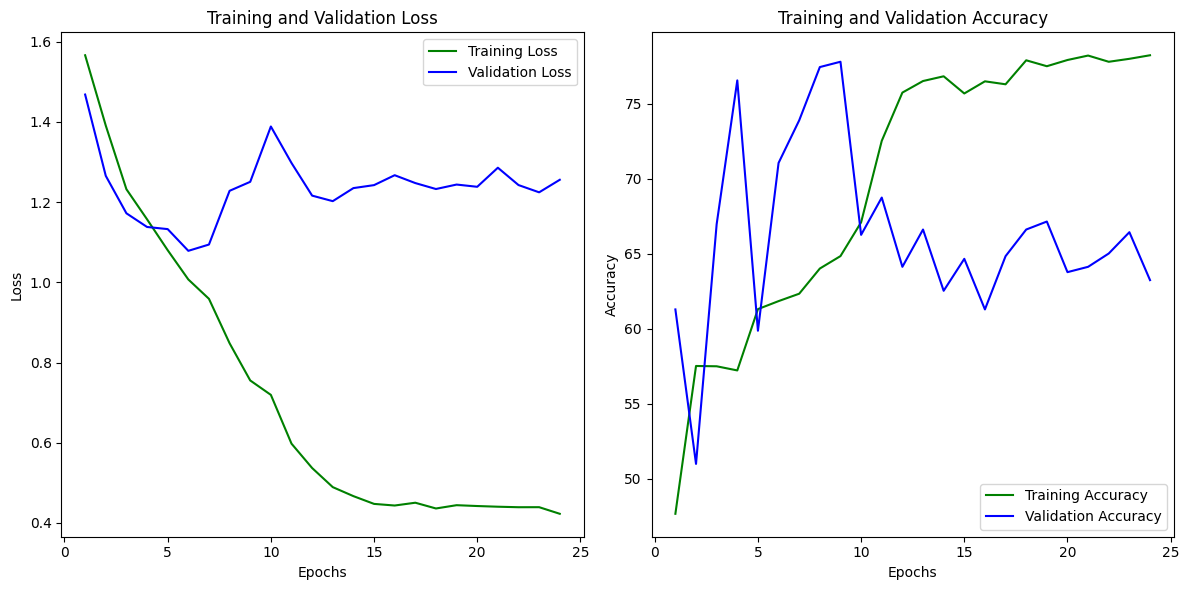


Epoch 25/35
-------------------------------
Epoch: 24, Learning Rate: 0.000001 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.494653, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 32.307397, correct predictions: 849, total: 1136
Batch 140/317 processed, running loss: 59.005284, correct predictions: 1744, total: 2256
Batch 210/317 processed, running loss: 88.487576, correct predictions: 2617, total: 3376
Batch 280/317 processed, running loss: 121.584703, correct predictions: 3481, total: 4496

Training Loss per batch = 0.433029	Accuracy on Training set = 77.696563% [3933/5062]

Validation Loss per batch = 1.234253	Accuracy on Validation set = 65.541741% [369/563]
Train Loss: 0.4330, Train Accuracy: 77.6966
Valid Loss: 1.2343, Valid Accuracy: 65.5417


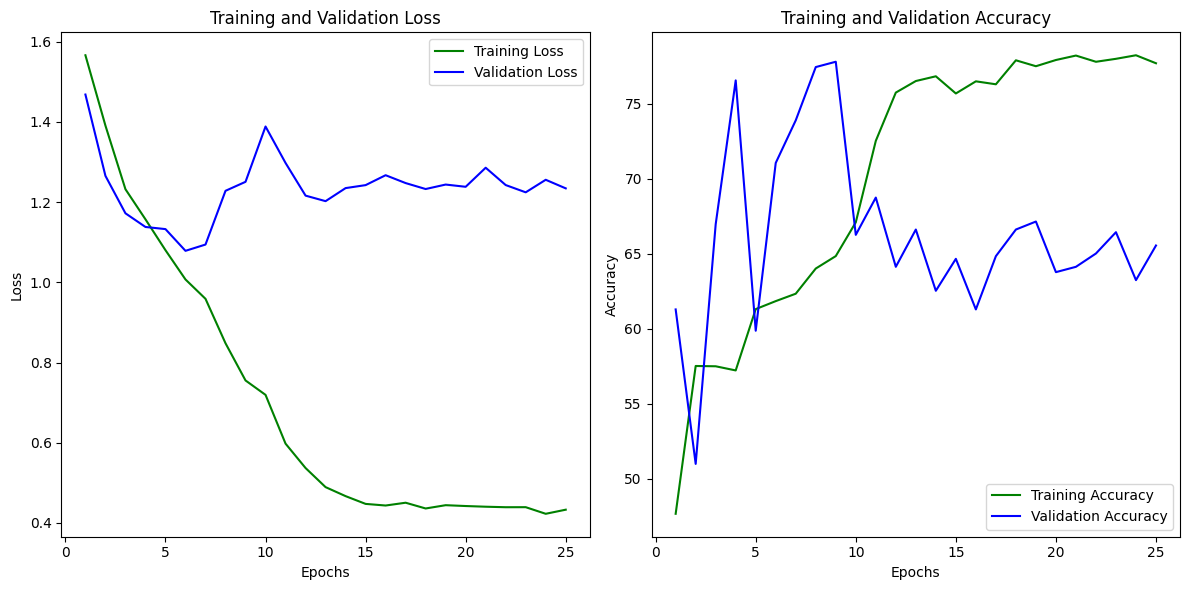


Epoch 26/35
-------------------------------
Epoch: 25, Learning Rate: 0.000001 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.266097, correct predictions: 15, total: 16
Batch 70/317 processed, running loss: 32.748385, correct predictions: 890, total: 1136
Batch 140/317 processed, running loss: 62.134440, correct predictions: 1775, total: 2256
Batch 210/317 processed, running loss: 89.722081, correct predictions: 2658, total: 3376
Batch 280/317 processed, running loss: 120.461958, correct predictions: 3547, total: 4496

Training Loss per batch = 0.428476	Accuracy on Training set = 79.079415% [4003/5062]

Validation Loss per batch = 1.221795	Accuracy on Validation set = 66.962700% [377/563]
Train Loss: 0.4285, Train Accuracy: 79.0794
Valid Loss: 1.2218, Valid Accuracy: 66.9627


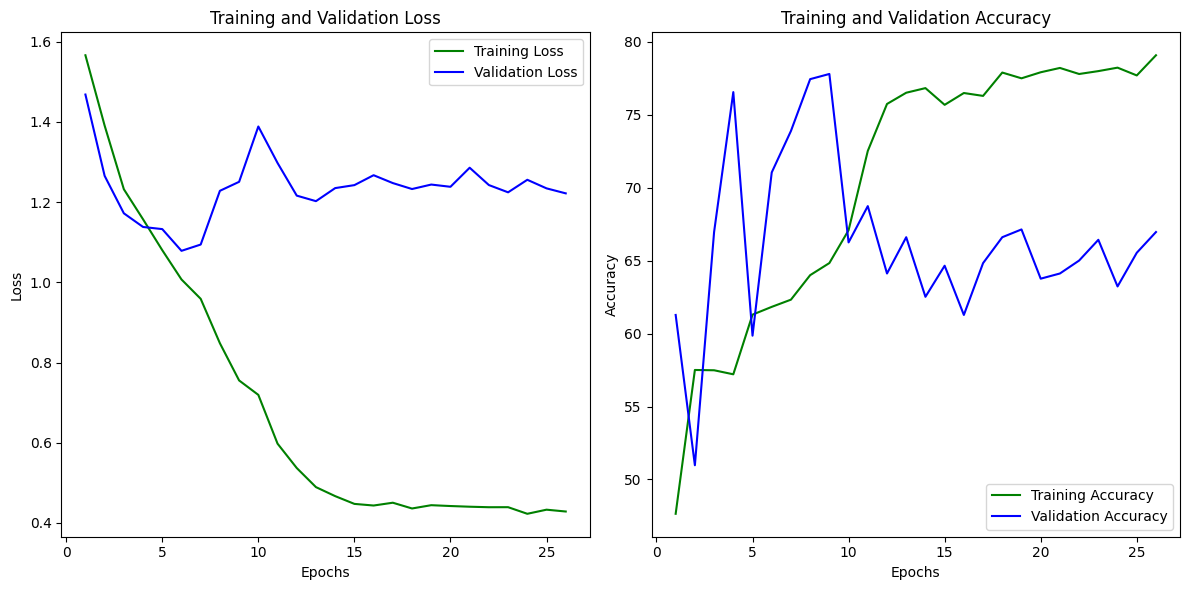


Epoch 27/35
-------------------------------
Epoch: 26, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.237965, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 30.723734, correct predictions: 909, total: 1136
Batch 140/317 processed, running loss: 64.358832, correct predictions: 1773, total: 2256
Batch 210/317 processed, running loss: 93.913415, correct predictions: 2649, total: 3376
Batch 280/317 processed, running loss: 126.281349, correct predictions: 3516, total: 4496

Training Loss per batch = 0.441461	Accuracy on Training set = 78.052153% [3951/5062]

Validation Loss per batch = 1.257511	Accuracy on Validation set = 62.877442% [354/563]
Train Loss: 0.4415, Train Accuracy: 78.0522
Valid Loss: 1.2575, Valid Accuracy: 62.8774


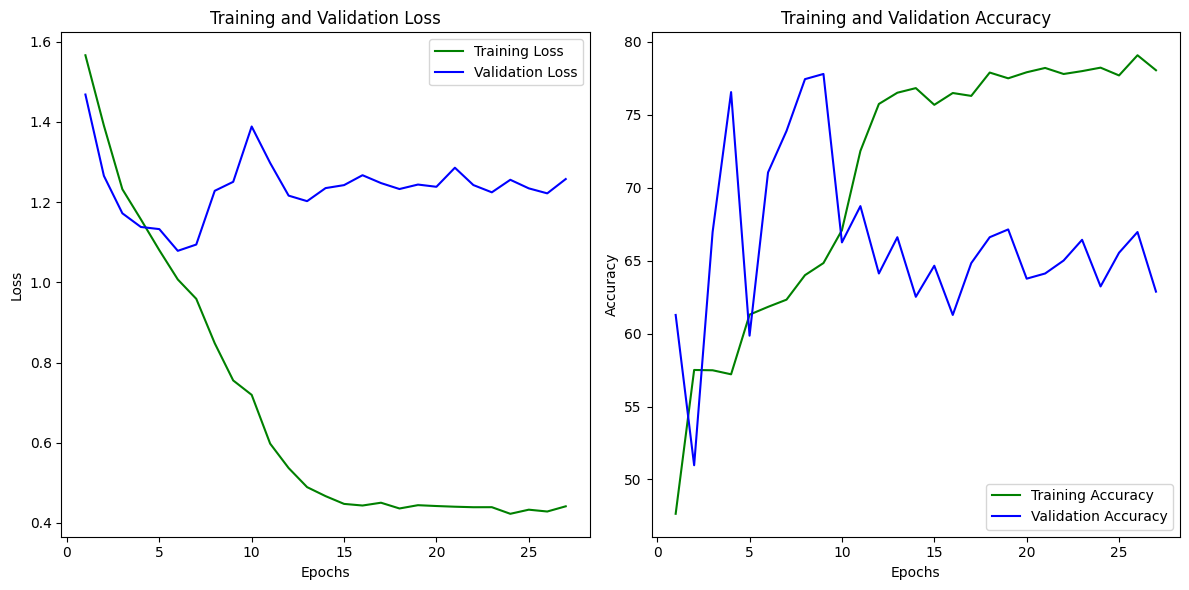


Epoch 28/35
-------------------------------
Epoch: 27, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.433091, correct predictions: 13, total: 16
Batch 70/317 processed, running loss: 34.369306, correct predictions: 878, total: 1136
Batch 140/317 processed, running loss: 65.744839, correct predictions: 1755, total: 2256
Batch 210/317 processed, running loss: 99.100817, correct predictions: 2627, total: 3376
Batch 280/317 processed, running loss: 128.635932, correct predictions: 3524, total: 4496

Training Loss per batch = 0.456505	Accuracy on Training set = 78.249704% [3961/5062]

Validation Loss per batch = 1.229093	Accuracy on Validation set = 66.607460% [375/563]
Train Loss: 0.4565, Train Accuracy: 78.2497
Valid Loss: 1.2291, Valid Accuracy: 66.6075


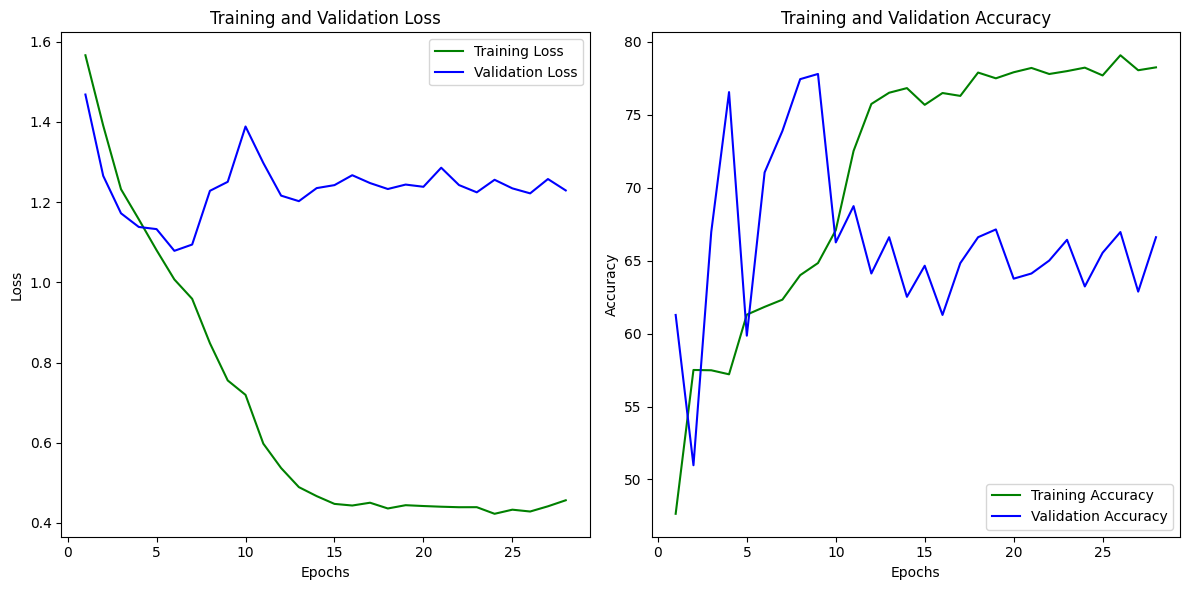


Epoch 29/35
-------------------------------
Epoch: 28, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.391562, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 30.582195, correct predictions: 887, total: 1136
Batch 140/317 processed, running loss: 61.751497, correct predictions: 1740, total: 2256
Batch 210/317 processed, running loss: 91.625649, correct predictions: 2616, total: 3376
Batch 280/317 processed, running loss: 121.945937, correct predictions: 3497, total: 4496

Training Loss per batch = 0.433458	Accuracy on Training set = 77.558277% [3926/5062]

Validation Loss per batch = 1.255069	Accuracy on Validation set = 66.074600% [372/563]
Train Loss: 0.4335, Train Accuracy: 77.5583
Valid Loss: 1.2551, Valid Accuracy: 66.0746


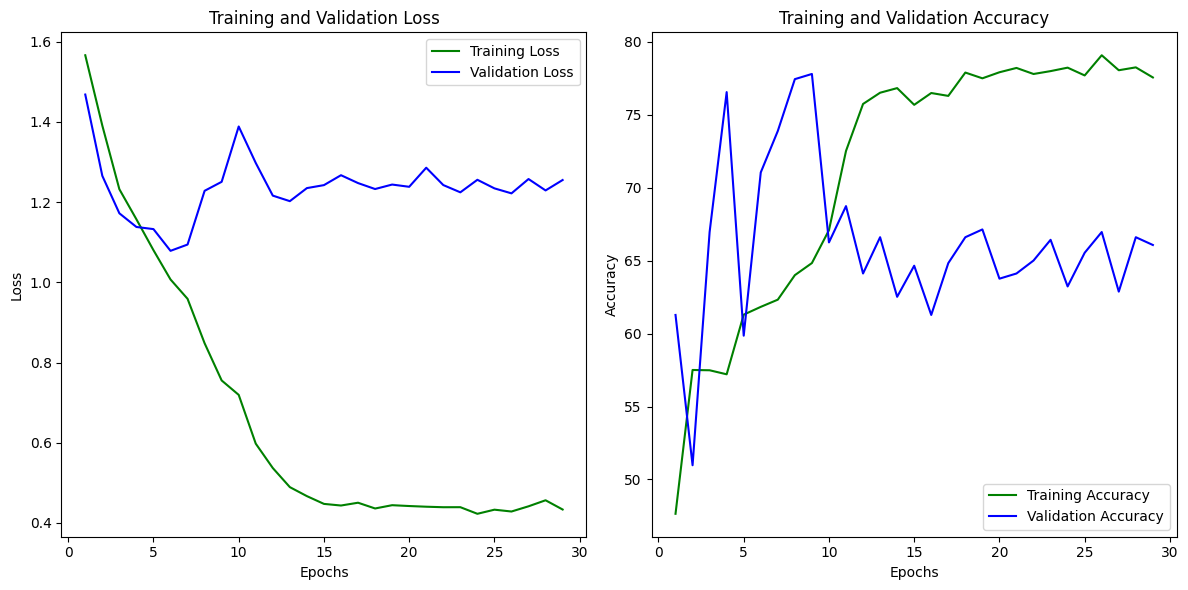


Epoch 30/35
-------------------------------
Epoch: 29, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.500930, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 32.807450, correct predictions: 891, total: 1136
Batch 140/317 processed, running loss: 61.257979, correct predictions: 1762, total: 2256
Batch 210/317 processed, running loss: 93.267885, correct predictions: 2621, total: 3376
Batch 280/317 processed, running loss: 124.492247, correct predictions: 3500, total: 4496

Training Loss per batch = 0.443644	Accuracy on Training set = 77.854603% [3941/5062]

Validation Loss per batch = 1.229360	Accuracy on Validation set = 64.120782% [361/563]
Train Loss: 0.4436, Train Accuracy: 77.8546
Valid Loss: 1.2294, Valid Accuracy: 64.1208


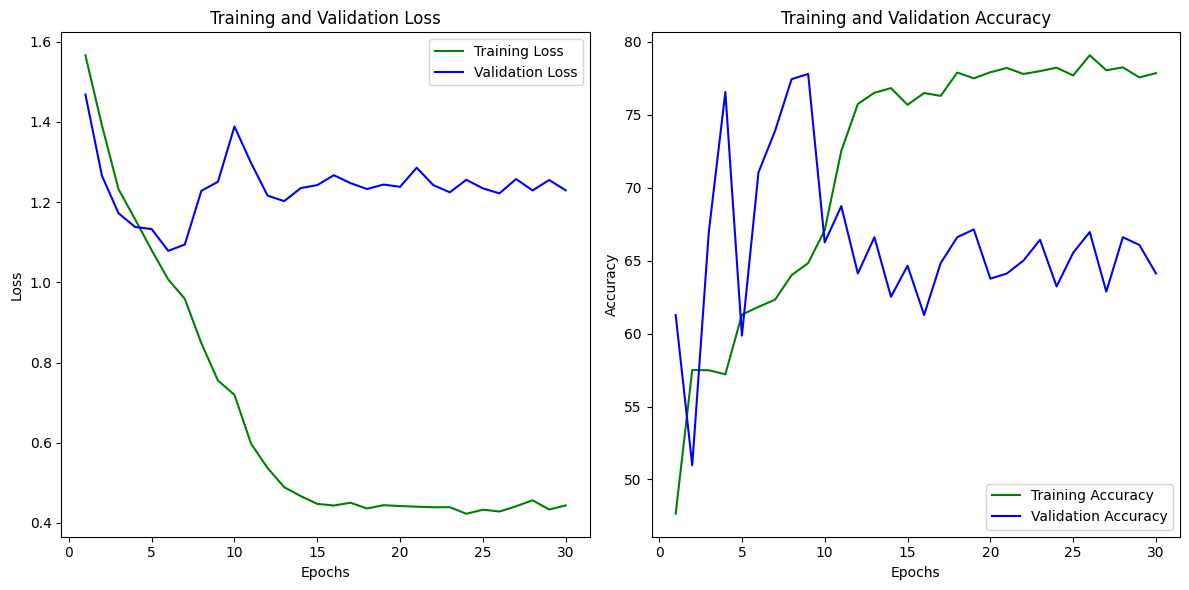


Epoch 31/35
-------------------------------
Epoch: 30, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.208671, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 29.903284, correct predictions: 898, total: 1136
Batch 140/317 processed, running loss: 60.699814, correct predictions: 1783, total: 2256
Batch 210/317 processed, running loss: 91.176033, correct predictions: 2681, total: 3376
Batch 280/317 processed, running loss: 124.328598, correct predictions: 3549, total: 4496

Training Loss per batch = 0.443663	Accuracy on Training set = 78.822600% [3990/5062]

Validation Loss per batch = 1.249860	Accuracy on Validation set = 63.232682% [356/563]
Train Loss: 0.4437, Train Accuracy: 78.8226
Valid Loss: 1.2499, Valid Accuracy: 63.2327


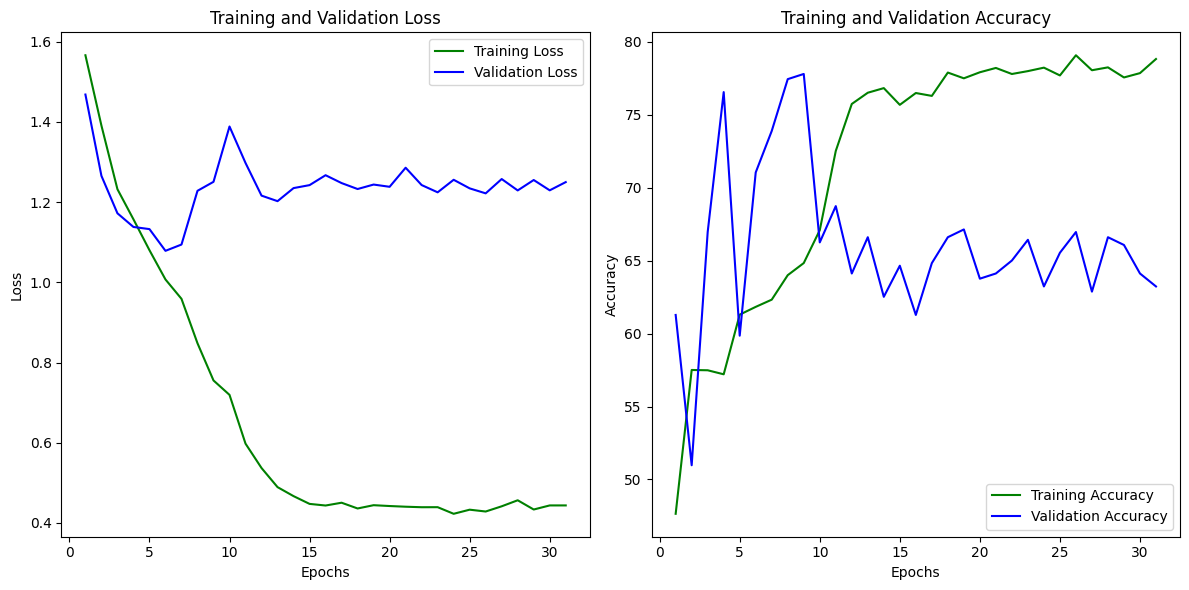


Epoch 32/35
-------------------------------
Epoch: 31, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.393861, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 30.155640, correct predictions: 870, total: 1136
Batch 140/317 processed, running loss: 60.182293, correct predictions: 1756, total: 2256
Batch 210/317 processed, running loss: 90.641562, correct predictions: 2631, total: 3376
Batch 280/317 processed, running loss: 122.557888, correct predictions: 3514, total: 4496

Training Loss per batch = 0.439347	Accuracy on Training set = 78.249704% [3961/5062]

Validation Loss per batch = 1.237735	Accuracy on Validation set = 64.831261% [365/563]
Train Loss: 0.4393, Train Accuracy: 78.2497
Valid Loss: 1.2377, Valid Accuracy: 64.8313


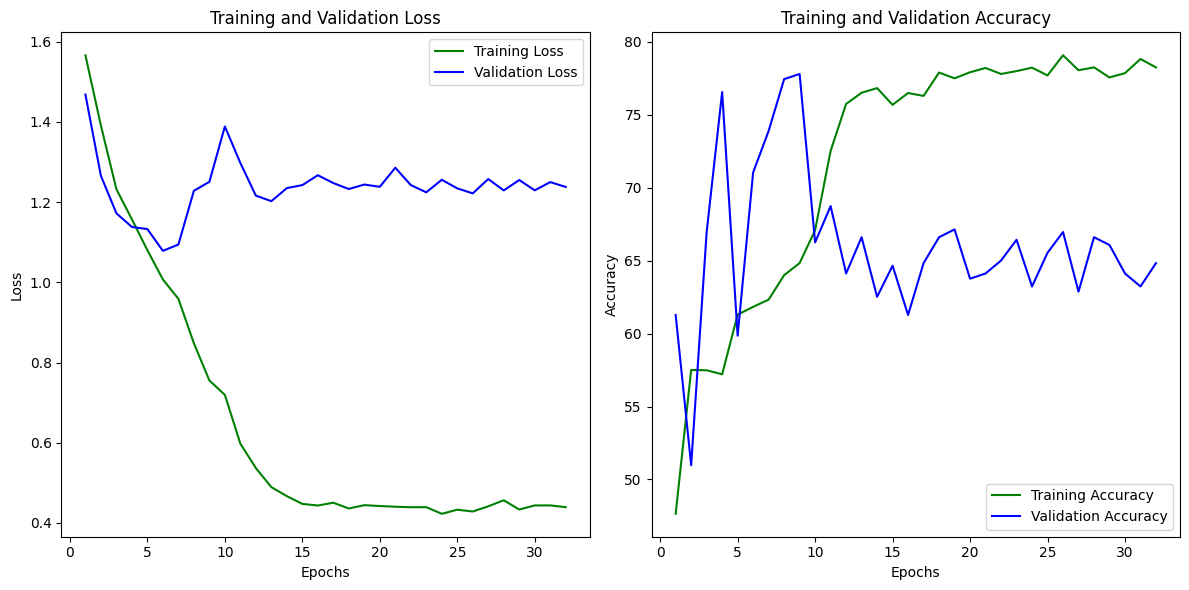


Epoch 33/35
-------------------------------
Epoch: 32, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.440796, correct predictions: 14, total: 16
Batch 70/317 processed, running loss: 31.030510, correct predictions: 881, total: 1136
Batch 140/317 processed, running loss: 62.888607, correct predictions: 1761, total: 2256
Batch 210/317 processed, running loss: 93.840820, correct predictions: 2638, total: 3376
Batch 280/317 processed, running loss: 125.746561, correct predictions: 3508, total: 4496

Training Loss per batch = 0.442828	Accuracy on Training set = 77.953378% [3946/5062]

Validation Loss per batch = 1.281438	Accuracy on Validation set = 65.896980% [371/563]
Train Loss: 0.4428, Train Accuracy: 77.9534
Valid Loss: 1.2814, Valid Accuracy: 65.8970


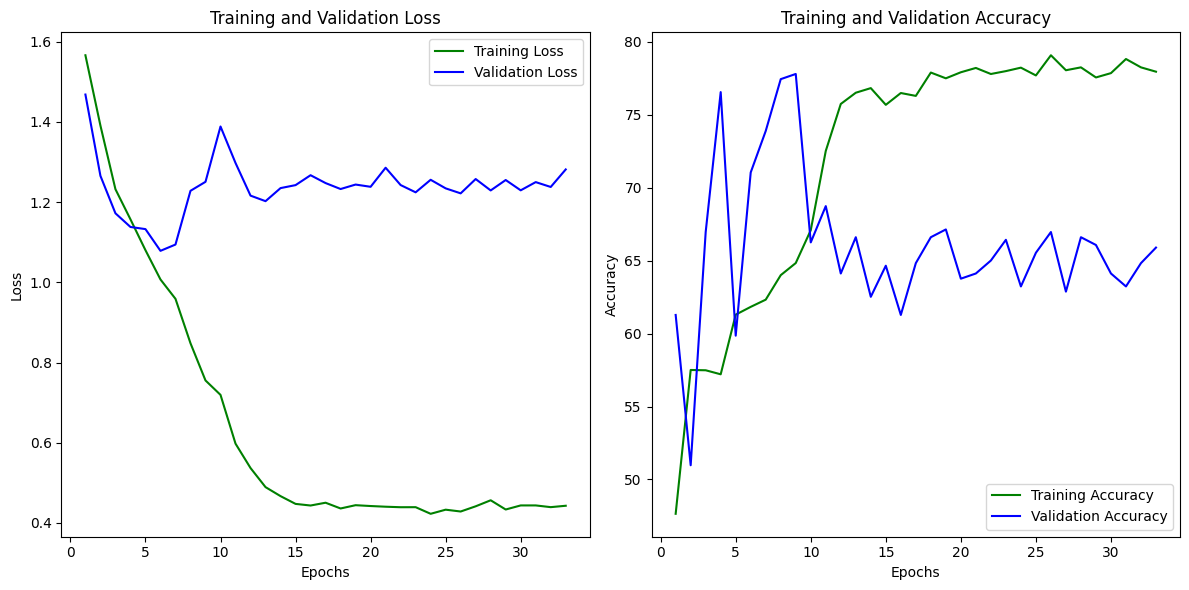


Epoch 34/35
-------------------------------
Epoch: 33, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.129915, correct predictions: 11, total: 16
Batch 70/317 processed, running loss: 31.669365, correct predictions: 884, total: 1136
Batch 140/317 processed, running loss: 64.432065, correct predictions: 1769, total: 2256
Batch 210/317 processed, running loss: 95.750350, correct predictions: 2626, total: 3376
Batch 280/317 processed, running loss: 126.651011, correct predictions: 3518, total: 4496

Training Loss per batch = 0.453593	Accuracy on Training set = 78.150928% [3956/5062]

Validation Loss per batch = 1.247173	Accuracy on Validation set = 65.186501% [367/563]
Train Loss: 0.4536, Train Accuracy: 78.1509
Valid Loss: 1.2472, Valid Accuracy: 65.1865


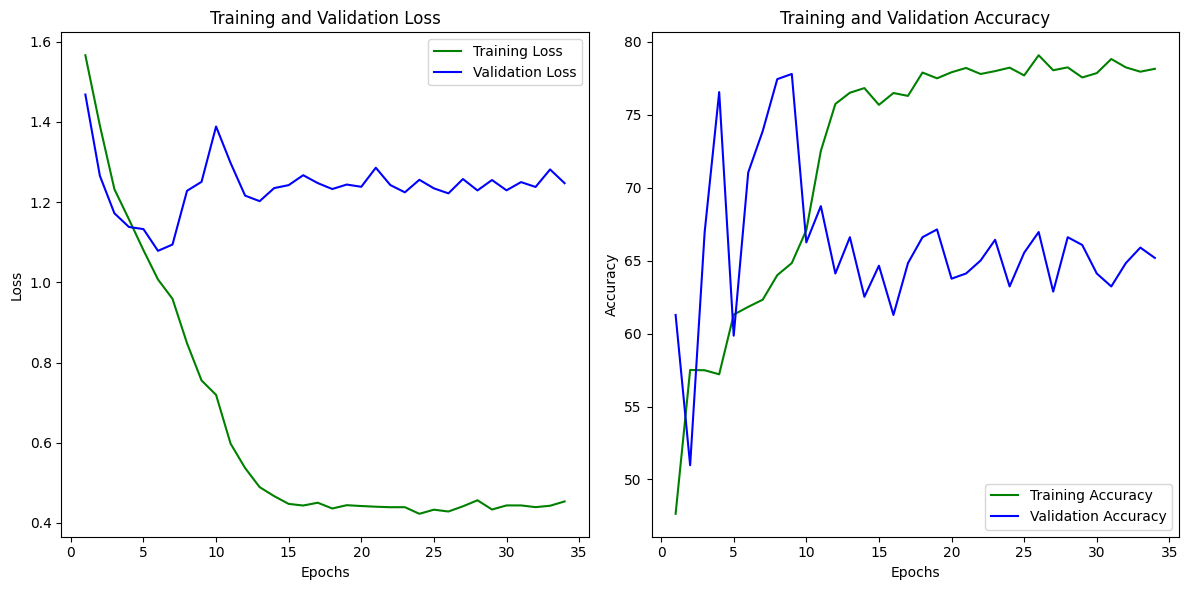


Epoch 35/35
-------------------------------
Epoch: 34, Learning Rate: 0.000000 


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


Batch 0/317 processed, running loss: 0.690831, correct predictions: 12, total: 16
Batch 70/317 processed, running loss: 32.387251, correct predictions: 883, total: 1136
Batch 140/317 processed, running loss: 61.875194, correct predictions: 1758, total: 2256
Batch 210/317 processed, running loss: 95.533819, correct predictions: 2627, total: 3376
Batch 280/317 processed, running loss: 128.805550, correct predictions: 3494, total: 4496

Training Loss per batch = 0.457275	Accuracy on Training set = 77.736073% [3935/5062]

Validation Loss per batch = 1.212893	Accuracy on Validation set = 65.364121% [368/563]
Train Loss: 0.4573, Train Accuracy: 77.7361
Valid Loss: 1.2129, Valid Accuracy: 65.3641


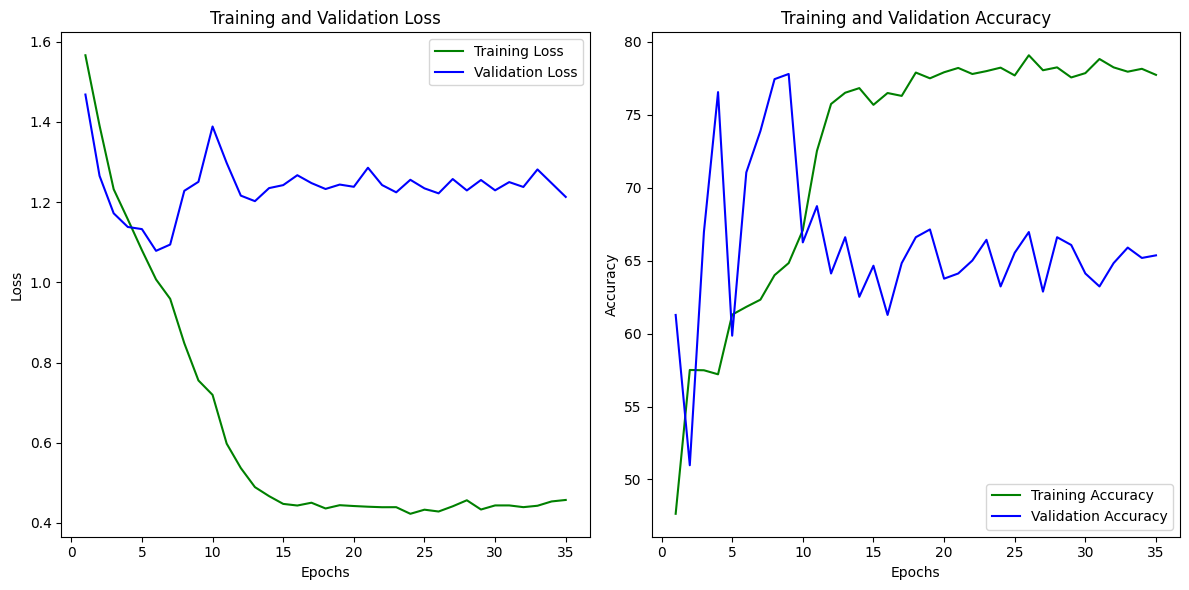


Training has completed!


<ipython-input-20-a06ff52dd9fb>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}, ignore_index=True)


In [21]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.005, weight_decay=1e-5)
nb_epochs = 35
patience = 50

#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs, patience)

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/unzip

In [ ]:
model = torch.load("DR_ResNet50_test.pt")
model.eval()  # Set the model to evaluation mode

# Store all the model predictions for the test set
all_preds = []
all_labels = []

# No need to track gradients for evaluation, saves memory and computations
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

# For multiclass case:
num_classes = cm.shape[0]  # assuming cm is a square matrix

for i in range(num_classes):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp  # sum across the row, excluding the diagonal element
    fp = cm[:, i].sum() - tp  # sum down the column, excluding the diagonal element
    tn = cm.sum() - fn - fp - tp

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"For class {i}, Sensitivity: {sensitivity}, Specificity: {specificity}")


In [ ]:
!nvidia-smi

In [ ]:
!pwd

In [ ]:
!zip -r data.zip test train